In [112]:
# Import libraries
import os
import pandas as pd
import missingno as msno
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import gaussian_kde
from scipy.spatial.distance import jensenshannon
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.covariance import EmpiricalCovariance, MinCovDet
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

import geopandas as gpd
import contextily as ctx

import seaborn as sns
import pyarrow as pa
import pyarrow.parquet as pq
from dateutil import parser
import zipfile
from collections import Counter

from modules.config import PROCESSED_DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, URL_LIST, POLLUTANTS, MUNICIPALITY

WATER_QUALITY_FILE = "water_quality_data.xlsb"
SUBDIR = "../data/raw/"
ALL_POLLUTANTS = [
 'ALC_FEN',
 'ALC_TOT',
 'CO3',
 'HCO3',
 'OH',
 'CLOROF_A',
 'COLI_FEC',
 'COLI_TOT',
 'E_COLI',
 'COT',
 'COT_SOL',
 'DBO_SOL',
 'DBO_TOT',
 'DQO_SOL',
 'DQO_TOT',
 'N_NH3',
 'N_NO2',
 'N_NO3',
 'N_ORG',
 'N_TOT',
 'N_TOTK',
 'TOX_D_48_UT',
 'TOX_D_48_SUP_UT',
 'TOX_D_48_FON_UT',
 'TOX_FIS_SUP_15_UT',
 'TOX_FIS_SUP_30_UT',
 'TOX_FIS_SUP_5_UT',
 'TOX_FIS_FON_15_UT',
 'TOX_FIS_FON_30_UT',
 'TOX_FIS_FON_5_UT',
 'TOX_V_15_UT',
 'TOX_V_30_UT',
 'TOX_V_5_UT',
 'AOXF',
 'AOXP',
 'AOXT',
 'P_TOT',
 'PO4_TOT',
 'ORTO_PO4',
 'COLOR_VER',
 'TRANSPARENCIA',
 'ABS_UV',
 'SDT',
 'CONDUC_CAMPO',
 'CONDUC_CAMPO_SUP',
 'CONDUC_CAMPO_MED',
 'CONDUC_CAMPO_FON',
 'pH_CAMPO',
 'pH_CAMPO_SUP',
 'pH_CAMPO_MED',
 'pH_CAMPO_FON',
 'SALINIDAD_SUP',
 'SALINIDAD_MED',
 'SALINIDAD_FON',
 'OD_%',
 'OD_mg/L',
 'OD_%_SUP',
 'OD_mg/L_SUP',
 'OD_%_MED',
 'OD_mg/L_MED',
 'OD_%_FON',
 'OD_mg/L_FON',
 '1,1,1,2_TTCETA',
 '1,1,2,2_TETRACLETAN',
 '1,1,2_TCETA',
 '1,1_DICLETILEN',
 '1,2,4_TRICLBENCEN',
 '1,2_DIBR_3_CLPROPAN',
 '1,2_DICLETAN',
 '1,2_DICLPROPAN',
 '1,2_DIFENILHIDRACINA',
 '1_C_NAF',
 '2,3_DICLOROFENOL_DCF',
 '2,4,5_T',
 '2,4,5_TRICLOROFENOL',
 '2,4,6_TRICLFENOL',
 '2,4_D_D_C_FENOXIACETICO',
 '2,4_DICLFENOL',
 '2,4_DIMETILFEN',
 '2,4_DINITOL',
 '2,4_DNF',
 '2,6_DINTOL',
 '2_CEVE',
 '2_CF',
 '2_CLNAFT',
 '2_NIFENOL',
 '4_BRFENFENETER',
 '4_NITROFENOL',
 'ACENAF',
 'ACENAFTIL',
 'ANTRA',
 'BEN_A_ANT',
 'BEN_A_PIR',
 'BEN_B_FANT',
 'BEN_G,H,I_PER',
 'BEN_K_FANT',
 'CRISENO',
 'DIBEN_ANT',
 'FENANTRENO',
 'FLUORANTENO',
 'FLUORENO',
 'IND_PIR',
 'NAFTALENO',
 'PIRENO',
 'HAPS',
 'ACRILONITRILO',
 'ACROLEINA',
 'AL_TOT',
 'ALACLOR',
 'ALDICARB',
 'ALDRIN',
 'ATRAZINA',
 'B_TOT',
 'B2_ETILHEXIL_FTALATO',
 'BA_TOT',
 'BE_TOT',
 'BENCENO',
 'BENCIDINA',
 'BIS2_CLETETER',
 'BIS2_CLIOISOPET',
 'BOLSTAR',
 'BPCS',
 'BR_CLMET',
 'BROMOMETANO',
 'CARBOFURANO',
 'CIS_1,2_DICLETEN',
 'CL_BENC',
 'CL_METILENO',
 'CL_RES',
 'CLORATALONIL',
 'CLORDANO',
 'CLOROMETANO',
 'CLOROTOLURON',
 'CLORPIRYFOS',
 'CLORURO_DE_VINILO',
 'CLORUROS_TOT',
 'COUMAFOS',
 'CR_HEX',
 'CYANACINA',
 'DALAPON',
 'DDD',
 'DDE',
 'DDT',
 'DELTAMETRINA',
 'DEMETON_S',
 'DI_2_ETILEXIL_ADIPATO',
 'DIAZINON',
 'DICAMBA',
 'DICLORVOS',
 'DIELDRIN',
 'DIET_FTAL',
 'DIMETIL_FTAL',
 'DIMETOATO',
 'DINITRO_O_CRESOL',
 'DINOSEB',
 'DIURON',
 'END_ALD',
 'ENDO_SUL',
 'ALFA_ENDO',
 'BETA_ENDO',
 'ENDO_SULSO4',
 'ENDRIN',
 'ENTEROC_FEC',
 'EPN',
 'ESTIRENO',
 'ETILBENCENO',
 'ETOPROP',
 'FE_TOT',
 'FENITROTION',
 'FENOL',
 'FENOLES_TOT',
 'FENSULFOTION',
 'FENTION',
 'FLUORUROS_TOT',
 'FORATO',
 'GLIFOSATO',
 'GRAS_ACEI',
 'H_HELMINTOS',
 'HEPTA_EPOX',
 'HEPTACLOR',
 'HEXACL_BENC',
 'HEXACL_BUT',
 'HEXACL_CICLOPEN',
 'HEXACL_ETANO',
 'ISO_FOR',
 'ISOPROTURON',
 'K_TOT',
 'LINURON',
 'MALATION',
 'MAT_FLOTANTE',
 'MCPA',
 'MERFOS',
 'METIL_AZINF_GUT',
 'METILPARATION',
 'METILTERBUTILETER_MTBE_',
 'METOLACLOR',
 'METOXICLO',
 'MEVINFOS',
 'MIREX',
 'MN_TOT',
 'MO_TOT',
 'MOLINATO',
 'N_NITROS_DIMETILA',
 'N_NITROS_N_PROPAM',
 'N_NITROSODIFENILAMINA',
 'NA_TOT',
 'NITROBENCENO',
 'OXAMIL',
 'PARATION',
 'PCBEN',
 'PENDIMETALIN',
 'PENTACLOROFENOL',
 'PICLORAN',
 'PIRYPROXYFEN',
 'RONNEL',
 'SAAM',
 'SB_TOT',
 'SE_TOT',
 'SILVEX',
 'SIMAZINA',
 'SIO2',
 'SO4_TOT',
 'SOLID_SED',
 'SST',
 'SULFOTEP',
 'SULFUROS_TOT',
 'TALIO',
 'TERBUFOS',
 'TERBUTILAZINA',
 'TETRACL_CARB',
 'TETRACLOROETILENO_',
 'TOKUTION',
 'TOLUENO',
 'TOXAFENO',
 'TRANS_1,2_DICLOROETILENO',
 'TRIALATO',
 'TRICLORANATO',
 'TRICLORFON',
 'TRICLOROETILENO',
 'TRICLOROFLUOROMETANO',
 'TRIFLURALIN',
 'TURBIEDAD',
 'AS_TOT',
 'CD_TOT',
 'CR_TOT',
 'HG_TOT',
 'NI_TOT',
 'PB_TOT',
 'CN_TOT',
 'CU_TOT',
 'ZN_TOT',
 'POT_REDOX_CAMPO',
 'POT_REDOX_CAMPO_FON',
 'POT_REDOX_CAMPO_MED',
 'POT_REDOX_CAMPO_SUP',
 'ACENAF_8310',
 'ACENAFTIL_8310',
 'ANTRA_8310',
 'BEN_A_ANT_8310',
 'BEN_A_PIR_8310',
 'BEN_B_FANT_8310',
 'BEN_G,H,I_PER_8310',
 'BEN_K_FANT_8310',
 'CRISENO_8310',
 'DIBEN_ANT_8310',
 'FENANTRENO_8310',
 'FLUORANTENO_8310',
 'FLUORENO_8310',
 'IND_PIR_8310',
 'NAFTALENO_8310',
 'PIRENO_8310',
 'HAPS_8310',
 '1,2_DICLBENC',
 '1,3_DICLBEN',
 '1,4_DICLBEN',
 'DICLOROBENCENOS',
 'BR_DICLMET',
 'BROMOF',
 'CLOROFORMO',
 'DIBR_CLMET',
 'THMs',
 'M,P_XILENO',
 'O_XILENO',
 'XILEN_ISOMEROS',
 'ALFA_BHC',
 'BETA_BHC',
 'GAMA_BHC_LIN',
 'DELTA_BHC',
 'BHC_ISOMEROS',
 'CA_TOT',
 'MG_TOT',
 'DUR_TOT',
 'TEMP_AMB',
 'TEMP_AGUA',
 'TEMP_AGUA_SUP',
 'TEMP_AGUA_MED',
 'TEMP_AGUA_FON',
 'PROFUNDIDAD',
 'CAUDAL',
 'CLORUROS_SOL',
 'FLUORUROS_SOL',
 'SO4_SOL',
 'AS_SOL',
 'CD_SOL',
 'CR_SOL',
 'FE_SOL',
 'MN_SOL',
 'HG_SOL',
 'PB_SOL',
 'ZN_SOL',
 'AL_SOL',
 'CU_SOL',
 'TALIO_SOL',
 'NI_SOL',
 'CA_SOL',
 'MG_SOL',
 'K_SOL',
 'NA_SOL',
 'SULFUROS_SOL',
 'BA_SOL',
 'SB_SOL',
 'AG_TOT',
 'S',
 'AMPA',
 'V_TOT',
 'SE',
 'SSV',
 'C.MESÓFILOS AEROBIOS',
 'DUR_Ca',
 'DUR_Mg',
 'NH4',
 'ST',
 'DIBR_MET',
 'DIBROMOETILENO',
 'S_TOT',
 '1,1-DICLOROPROPILENO',
 '1,2,3_TRICLBENCEN',
 '1,2-DIBR_ETA',
 '1,3,5-TRIMETILBENCENO',
 '1,3_DICLPROPAN',
 '2_CLOROTOLUENO',
 '2_METILFEN',
 '4_CLOROTOLUENO',
 '4-ISOPROPILTOLUENO',
 'ALC_A',
 'AZOBENCENO',
 'BIS_2_CLOROETOXI_MET',
 'BISMUTO',
 'BROMATOS',
 'BROMOBENCENO',
 'BUTILBENCILFTALATO',
 'CARBAZOLA',
 'CIS-CLORDANO',
 'CLORAMINAS_COMO_CL2_',
 'CLORITOS',
 'CLOROF_B',
 'CLOROF_C',
 'CO_TOT',
 'COLOR_APA',
 'COLOR_VER_436',
 'COLOR_VER_525',
 'COLOR_VER_620',
 'COMP_ORG_NO_HALOG_FID_CONH',
 'CONDUC_LAB',
 'COP',
 'DIBENZOFURANO',
 'DIBUTILFTALATO (DBP)',
 'DICLOROMETANO',
 'DI-OCTILFTALATO',
 'DIQUAT',
 'ENDOSULFAN II',
 'ENDOTAL',
 'ENDRÍN CETONA',
 'HIDROCAR_F_MED',
 'HIDROCAR_F_PES',
 'ISOPROPILBENCENO',
 'Li_TOT',
 'N_NO3-N_NO2',
 'N_ORG_SOL',
 'N-BUTILBENCENO',
 'N-PROPILBENCENO',
 'O-NITROANILINA',
 'P_INORG',
 'P_INORG_DIS',
 'P_ORG',
 'P-CLOROANILINA',
 'pH_LAB',
 'SALINIDAD ',
 'SDF',
 'SDV',
 'SEC-BUTILBENCENO',
 'SN_TOT',
 'SR_TOT',
 'SSF',
 'STF',
 'STV',
 'TALIO_TOT',
 'TER-BUTILBENCENO',
 'Ti_TOT',
 'TRANS-CLORDANO',
 'FORMALDEHIDO',
 'CLORATOS',
 'ACID_CLOROACE',
 'ACID_DICLOROACE',
 'ACID_TRICLOROACE'
 ]

### Load data
We upload the data from the sites and the results of the measurements of the different pollutants. Merge df_water_site and df_water_result DataFrames using 'CLAVE SITIO' as the key. The 'inner' join returns only rows with matching values in both DataFrames. We select the columns required for the study, and in this case we need to select all the pollulants.

In [2]:
df_water_site = pd.read_excel(SUBDIR + WATER_QUALITY_FILE, sheet_name=0)
df_water_result = pd.read_excel(SUBDIR + WATER_QUALITY_FILE, sheet_name=1, parse_dates=['FECHA REALIZACIÓN'])

/tmp/ipykernel_9817/801284402.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_water_result = pd.read_excel(SUBDIR + WATER_QUALITY_FILE, sheet_name=1, parse_dates=['FECHA REALIZACIÓN'])


In [3]:
# Merging df_water_site and df_water_result DataFrames using 'CLAVE SITIO' as the key.
df_water_merged = pd.merge(
    df_water_site, 
    df_water_result, 
    on='CLAVE SITIO', 
    how='inner'
)

# Select the columns required for the study
df_water_merged_filtered = df_water_merged[
    ['CLAVE SITIO', 'ESTADO', 'MUNICIPIO', 'CUERPO DE AGUA', 'TIPO CUERPO DE AGUA', 'SUBTIPO CUERPO AGUA', 'LATITUD', 'LONGITUD', 'FECHA REALIZACIÓN'] + 
    ALL_POLLUTANTS
]

# Convert the 'FECHA REALIZACIÓN' column to the correct datetime format
# First convert the column to numeric
df_water_merged_filtered['FECHA REALIZACIÓN'] = pd.to_numeric(df_water_merged_filtered['FECHA REALIZACIÓN'], errors='coerce')

# Then convert to dates from Excel origin
df_water_merged_filtered['FECHA REALIZACIÓN'] = pd.to_datetime(
    df_water_merged_filtered['FECHA REALIZACIÓN'], 
    origin='1899-12-30', 
    unit='D'
)

# Filter the DataFrame to obtain only the records of the water bodies that are not "COASTAL" of the affected municipalities of the state of Sonora.
df_water_filtered_sonora = df_water_merged_filtered[
    (df_water_merged['ESTADO'] == 'SONORA') &
    (df_water_merged['MUNICIPIO'].isin(MUNICIPALITY))   
]
df_water_filtered_sonora = df_water_filtered_sonora[
    ~df_water_filtered_sonora['TIPO CUERPO DE AGUA'].str.contains('COSTERO', na=False)
]

# Clean the columns of pollutants by removing the '>' and '<' symbols and converting them to numeric
for column in ALL_POLLUTANTS:
    if column in df_water_filtered_sonora.columns:
        df_water_filtered_sonora[column] = df_water_filtered_sonora[column].astype(str)
        df_water_filtered_sonora[column] = (
            df_water_filtered_sonora[column]
            .str.replace('<', '', regex=False)
            .str.replace('>', '', regex=False)
        )
        df_water_filtered_sonora[column] = pd.to_numeric(df_water_filtered_sonora[column], errors='coerce')

# Sort by 'CLAVE SITIO' and 'FECHA REALIZACIÓN' in ascending order
df_water_filtered_sonora.sort_values(
    by=['CLAVE SITIO', 'FECHA REALIZACIÓN'], 
    ascending=True, 
    inplace=True, 
    ignore_index=True
)

/tmp/ipykernel_9817/4223021848.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_water_merged_filtered['FECHA REALIZACIÓN'] = pd.to_numeric(df_water_merged_filtered['FECHA REALIZACIÓN'], errors='coerce')
/tmp/ipykernel_9817/4223021848.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_water_merged_filtered['FECHA REALIZACIÓN'] = pd.to_datetime(


In [4]:
# Calculate the threshold of 70% of the DataFrame length
threshold = len(df_water_filtered_sonora) * 0.7

# Remove columns with more than 70% null data
df_drop_water_sonora = df_water_filtered_sonora.dropna(axis=1, thresh=threshold)

In [5]:
# Select the remaining columns of pollulants after removing the columns with some amount of null data
df_pollulants = df_drop_water_sonora.drop(columns=['CLAVE SITIO', 'ESTADO', 'MUNICIPIO', 'CUERPO DE AGUA',
                                                 'TIPO CUERPO DE AGUA', 'SUBTIPO CUERPO AGUA', 
                                                 'LATITUD', 'LONGITUD', 'FECHA REALIZACIÓN'])
# df_drop_water_sonora.loc[:, selected_cols].columns
df_pollulants

,COLI_FEC,E_COLI,COT,DBO_TOT,DQO_TOT,N_NH3,N_NO2,N_NO3,N_ORG,N_TOT,...,AS_TOT,CD_TOT,CR_TOT,HG_TOT,NI_TOT,PB_TOT,DUR_TOT,TEMP_AMB,TEMP_AGUA,CAUDAL
0,10.0,NaN,1.3280,NaN,NaN,0.053263,0.005,1.706396,0.32898,2.088639,...,0.0015,0.001301,0.0012,0.000201,0.00042,0.00154,507.3396,33.0,22.1,NaN
1,10.0,NaN,NaN,NaN,NaN,NaN,NaN,1.738000,NaN,NaN,...,0.0015,0.001301,0.0012,0.000201,0.00042,0.00154,514.0000,30.0,22.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0020,0.001000,0.0020,0.000701,0.00200,0.00200,NaN,NaN,NaN,NaN
3,1658.0,1274.0,NaN,2.0,10.0,NaN,NaN,NaN,NaN,NaN,...,0.0015,0.001301,0.0060,0.000201,0.01700,0.00154,NaN,29.0,29.0,337.0
4,10.0,NaN,0.4537,NaN,NaN,0.078194,0.005,1.054546,1.16265,2.295390,...,0.0015,0.001301,0.0012,0.000201,0.00042,0.00154,345.0658,29.0,19.8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,31.0,NaN,NaN,NaN,NaN,NaN,NaN,0.784000,NaN,NaN,...,0.0015,0.001301,0.0060,0.000201,NaN,0.00154,92.4000,27.0,24.0,NaN
469,10.0,NaN,0.8487,NaN,NaN,0.032294,0.005,5.602367,0.01774,5.652401,...,0.0015,0.001301,0.0056,0.000201,0.00042,0.00154,190.0259,32.0,27.7,NaN
470,10.0,NaN,NaN,NaN,NaN,NaN,NaN,5.164000,NaN,NaN,...,0.0080,0.001301,0.0012,0.000201,0.00042,0.00154,404.0000,32.0,27.0,NaN
471,10.0,NaN,NaN,NaN,NaN,NaN,NaN,1.602000,NaN,NaN,...,0.0015,0.001301,0.0012,0.000201,0.00042,0.00154,522.0000,27.0,25.0,NaN


In [6]:
# DataFrame for imputation methods
df_imputation_method = pd.DataFrame()

# DataFrame for imputation methods
df_imputation_method = pd.DataFrame()
df= pd.DataFrame()

# Forward Fill
df_imputation_method['COLI_FEC_ffill'] = df_pollulants['COLI_FEC'].fillna(method='ffill', inplace=False)
df_imputation_method['E_COLI_ffill'] = df_pollulants['E_COLI'].fillna(method='ffill', inplace=False)
df_imputation_method['N_TOT_ffill'] = df_pollulants['N_TOT'].fillna(method='ffill', inplace=False)

# BackFill
df_imputation_method['COLI_FEC_bfill'] = df_pollulants['COLI_FEC'].fillna(method='bfill', inplace=False)
df_imputation_method['E_COLI_bfill'] = df_pollulants['E_COLI'].fillna(method='bfill', inplace=False)
df_imputation_method['N_TOT_bfill'] = df_pollulants['N_TOT'].fillna(method='bfill', inplace=False)

# KNN Based
knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
df_imputation_method['COLI_FEC_knn'] = knn_imputer.fit_transform(df_pollulants[['COLI_FEC']])
df_imputation_method['E_COLI_knn'] = knn_imputer.fit_transform(df_pollulants[['E_COLI']])
df_imputation_method['N_TOT_knn'] = knn_imputer.fit_transform(df_pollulants[['N_TOT']])


# MICE
mice_imputer = IterativeImputer(max_iter=100, random_state=0)
imputed_values = mice_imputer.fit_transform(df_pollulants)
df_imputation_method['COLI_FEC_mice'] = imputed_values[:, df_pollulants.columns.get_loc('COLI_FEC')]
df_imputation_method['E_COLI_mice'] = imputed_values[:, df_pollulants.columns.get_loc('E_COLI')]
df_imputation_method['N_TOT_mice'] = imputed_values[:, df_pollulants.columns.get_loc('N_TOT')]

/tmp/ipykernel_9817/3843007284.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method['COLI_FEC_ffill'] = df_pollulants['COLI_FEC'].fillna(method='ffill', inplace=False)
/tmp/ipykernel_9817/3843007284.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method['E_COLI_ffill'] = df_pollulants['E_COLI'].fillna(method='ffill', inplace=False)
/tmp/ipykernel_9817/3843007284.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method['N_TOT_ffill'] = df_pollulants['N_TOT'].fillna(method='ffill', inplace=False)
/tmp/ipykernel_9817/3843007284.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_i

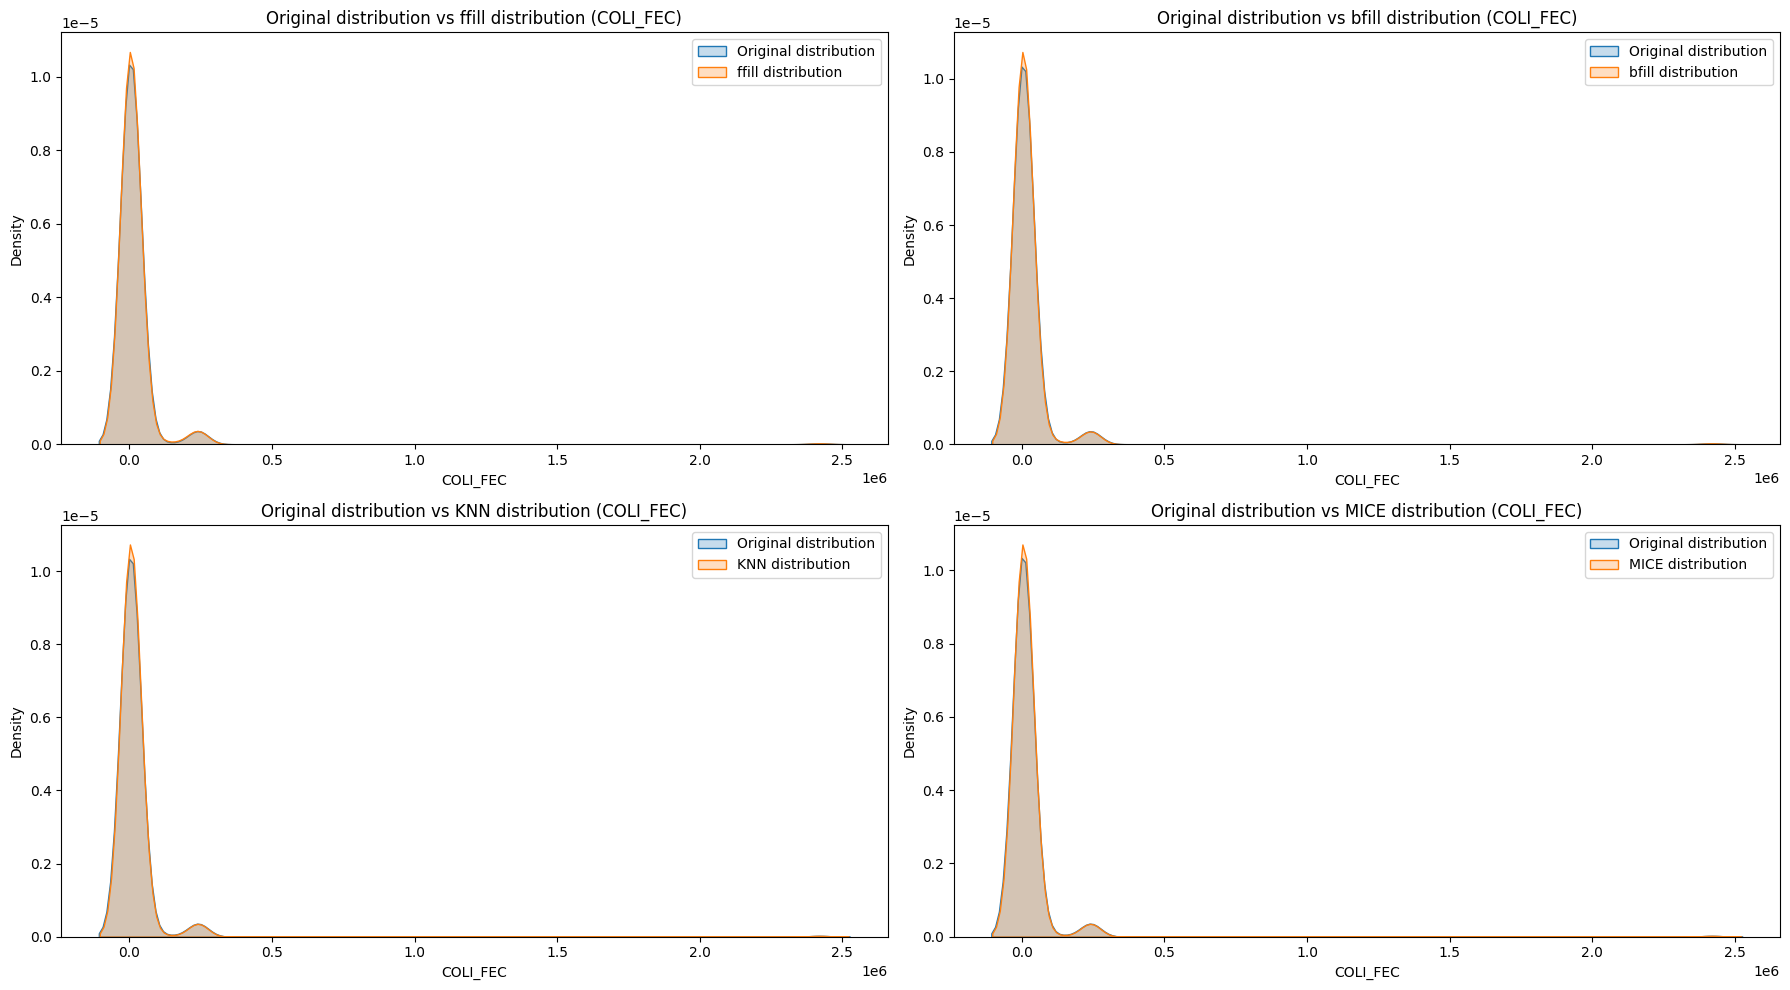

In [ ]:
# KDE graphs to compare the imputation methods for 'COLI_FEC'
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Subplot 1: ffill method
sns.kdeplot(df_drop_water_sonora['COLI_FEC'], label='Original distribution', fill=True, ax=axes[0, 0])
sns.kdeplot(df_imputation_method['COLI_FEC_ffill'], label='ffill distribution', fill=True, ax=axes[0, 0])
axes[0, 0].set_title('Original distribution vs ffill distribution (COLI_FEC)')
axes[0, 0].legend()

# Subplot 2: bfill method
sns.kdeplot(df_drop_water_sonora['COLI_FEC'], label='Original distribution', fill=True, ax=axes[0, 1])
sns.kdeplot(df_imputation_method['COLI_FEC_bfill'], label='bfill distribution', fill=True, ax=axes[0, 1])
axes[0, 1].set_title('Original distribution vs bfill distribution (COLI_FEC)')
axes[0, 1].legend()

# Subplot 3: KNN method
sns.kdeplot(df_drop_water_sonora['COLI_FEC'], label='Original distribution', fill=True, ax=axes[1, 0])
sns.kdeplot(df_imputation_method['COLI_FEC_knn'], label='KNN distribution', fill=True, ax=axes[1, 0])
axes[1, 0].set_title('Original distribution vs KNN distribution (COLI_FEC)')
axes[1, 0].legend()

# Subplot 4: MICE method
sns.kdeplot(df_drop_water_sonora['COLI_FEC'], label='Original distribution', fill=True, ax=axes[1, 1])
sns.kdeplot(df_imputation_method['COLI_FEC_mice'], label='MICE distribution', fill=True, ax=axes[1, 1])
axes[1, 1].set_title('Original distribution vs MICE distribution (COLI_FEC)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


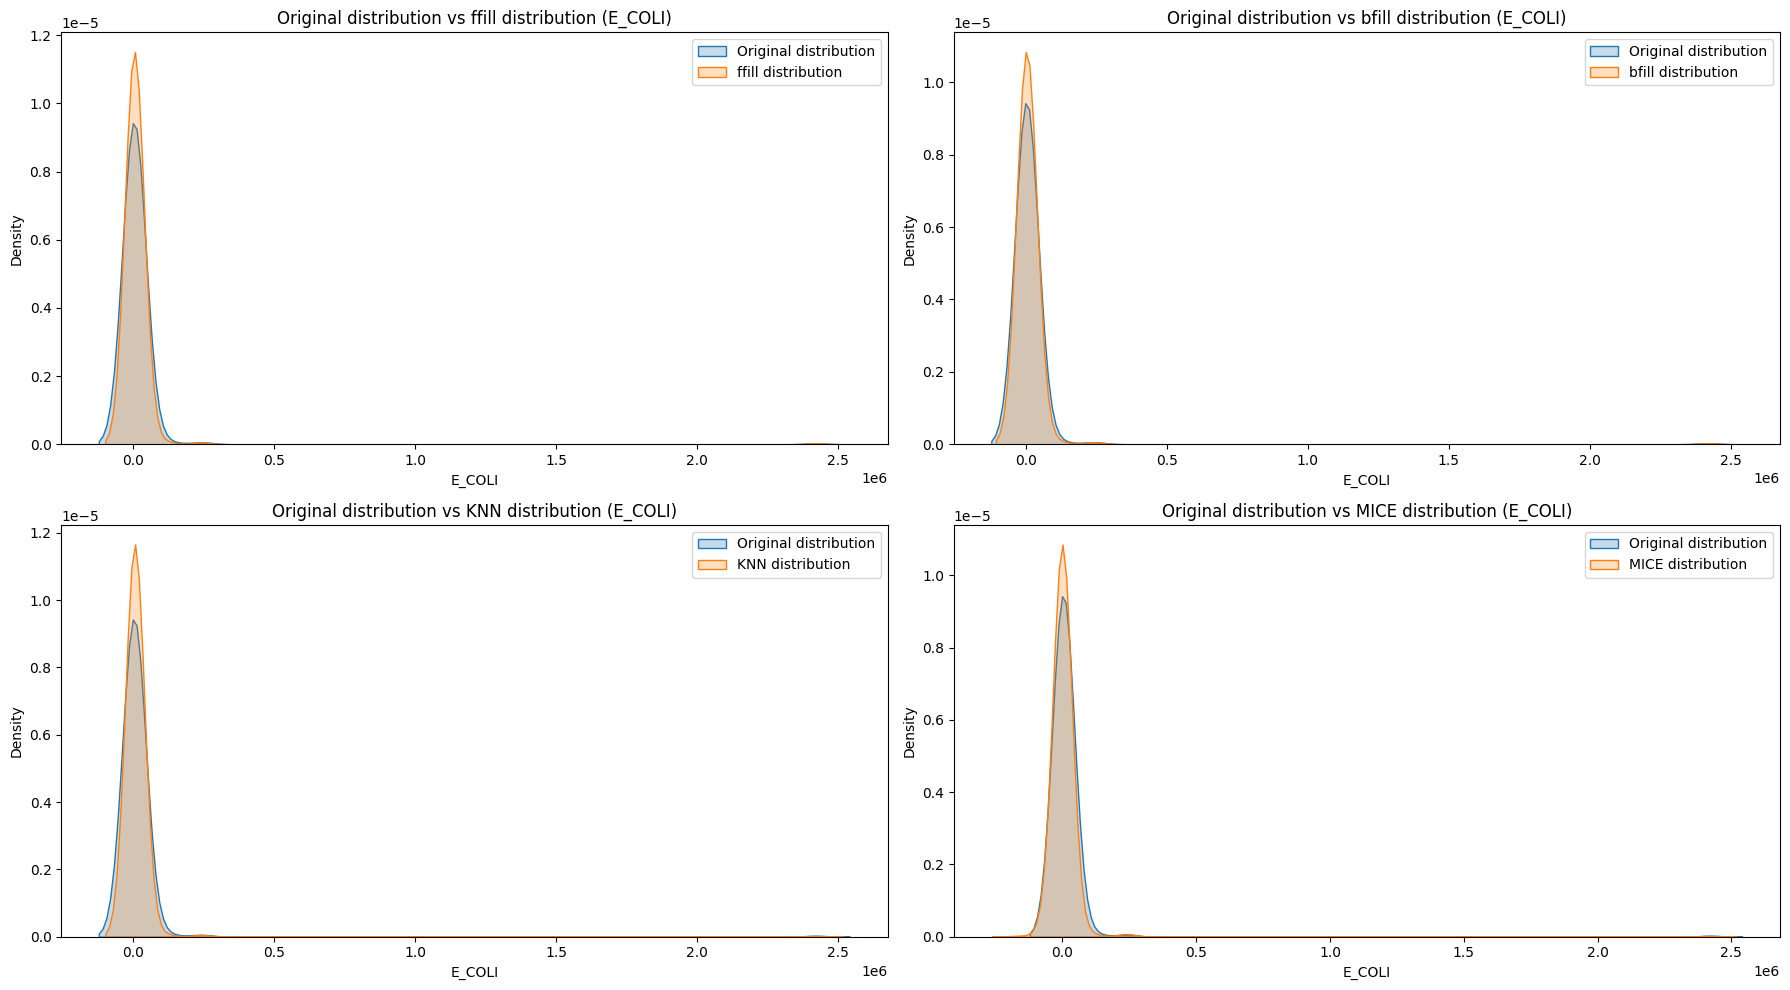

In [ ]:
# KDE graphs to compare the imputation methods for 'E_COLI'
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Subplot 1: ffill method
sns.kdeplot(df_drop_water_sonora['E_COLI'], label='Original distribution', fill=True, ax=axes[0, 0])
sns.kdeplot(df_imputation_method['E_COLI_ffill'], label='ffill distribution', fill=True, ax=axes[0, 0])
axes[0, 0].set_title('Original distribution vs ffill distribution (E_COLI)')
axes[0, 0].legend()

# Subplot 2: bfill method
sns.kdeplot(df_drop_water_sonora['E_COLI'], label='Original distribution', fill=True, ax=axes[0, 1])
sns.kdeplot(df_imputation_method['E_COLI_bfill'], label='bfill distribution', fill=True, ax=axes[0, 1])
axes[0, 1].set_title('Original distribution vs bfill distribution (E_COLI)')
axes[0, 1].legend()

# Subplot 3: KNN method
sns.kdeplot(df_drop_water_sonora['E_COLI'], label='Original distribution', fill=True, ax=axes[1, 0])
sns.kdeplot(df_imputation_method['E_COLI_knn'], label='KNN distribution', fill=True, ax=axes[1, 0])
axes[1, 0].set_title('Original distribution vs KNN distribution (E_COLI)')
axes[1, 0].legend()

# Subplot 4: MICE method
sns.kdeplot(df_drop_water_sonora['E_COLI'], label='Original distribution', fill=True, ax=axes[1, 1])
sns.kdeplot(df_imputation_method['E_COLI_mice'], label='MICE distribution', fill=True, ax=axes[1, 1])
axes[1, 1].set_title('Original distribution vs MICE distribution (E_COLI)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


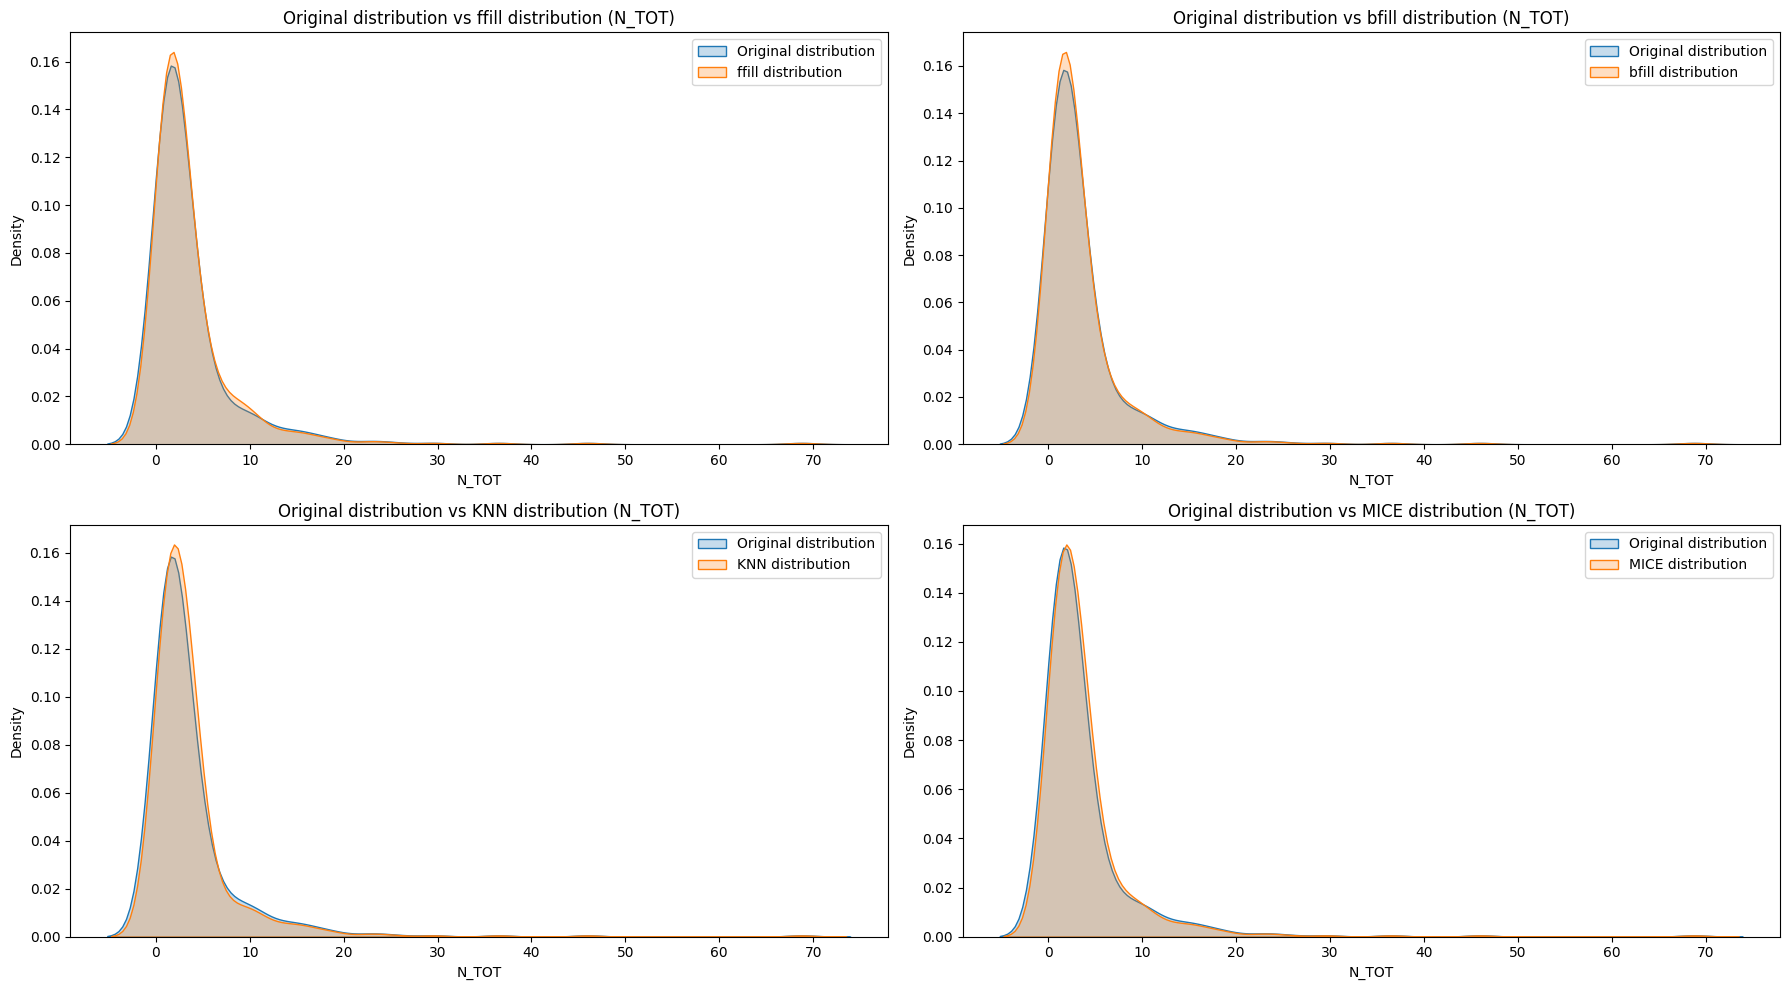

In [8]:
# KDE graphs to compare the imputation methods for 'N_TOT'
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Subplot 1: ffill method
sns.kdeplot(df_drop_water_sonora['N_TOT'], label='Original distribution', fill=True, ax=axes[0, 0])
sns.kdeplot(df_imputation_method['N_TOT_ffill'], label='ffill distribution', fill=True, ax=axes[0, 0])
axes[0, 0].set_title('Original distribution vs ffill distribution (N_TOT)')
axes[0, 0].legend()

# Subplot 2: bfill method
sns.kdeplot(df_drop_water_sonora['N_TOT'], label='Original distribution', fill=True, ax=axes[0, 1])
sns.kdeplot(df_imputation_method['N_TOT_bfill'], label='bfill distribution', fill=True, ax=axes[0, 1])
axes[0, 1].set_title('Original distribution vs bfill distribution (N_TOT)')
axes[0, 1].legend()

# Subplot 3: KNN method
sns.kdeplot(df_drop_water_sonora['N_TOT'], label='Original distribution', fill=True, ax=axes[1, 0])
sns.kdeplot(df_imputation_method['N_TOT_knn'], label='KNN distribution', fill=True, ax=axes[1, 0])
axes[1, 0].set_title('Original distribution vs KNN distribution (N_TOT)')
axes[1, 0].legend()

# Subplot 4: MICE method
sns.kdeplot(df_drop_water_sonora['N_TOT'], label='Original distribution', fill=True, ax=axes[1, 1])
sns.kdeplot(df_imputation_method['N_TOT_mice'], label='MICE distribution', fill=True, ax=axes[1, 1])
axes[1, 1].set_title('Original distribution vs MICE distribution (N_TOT)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


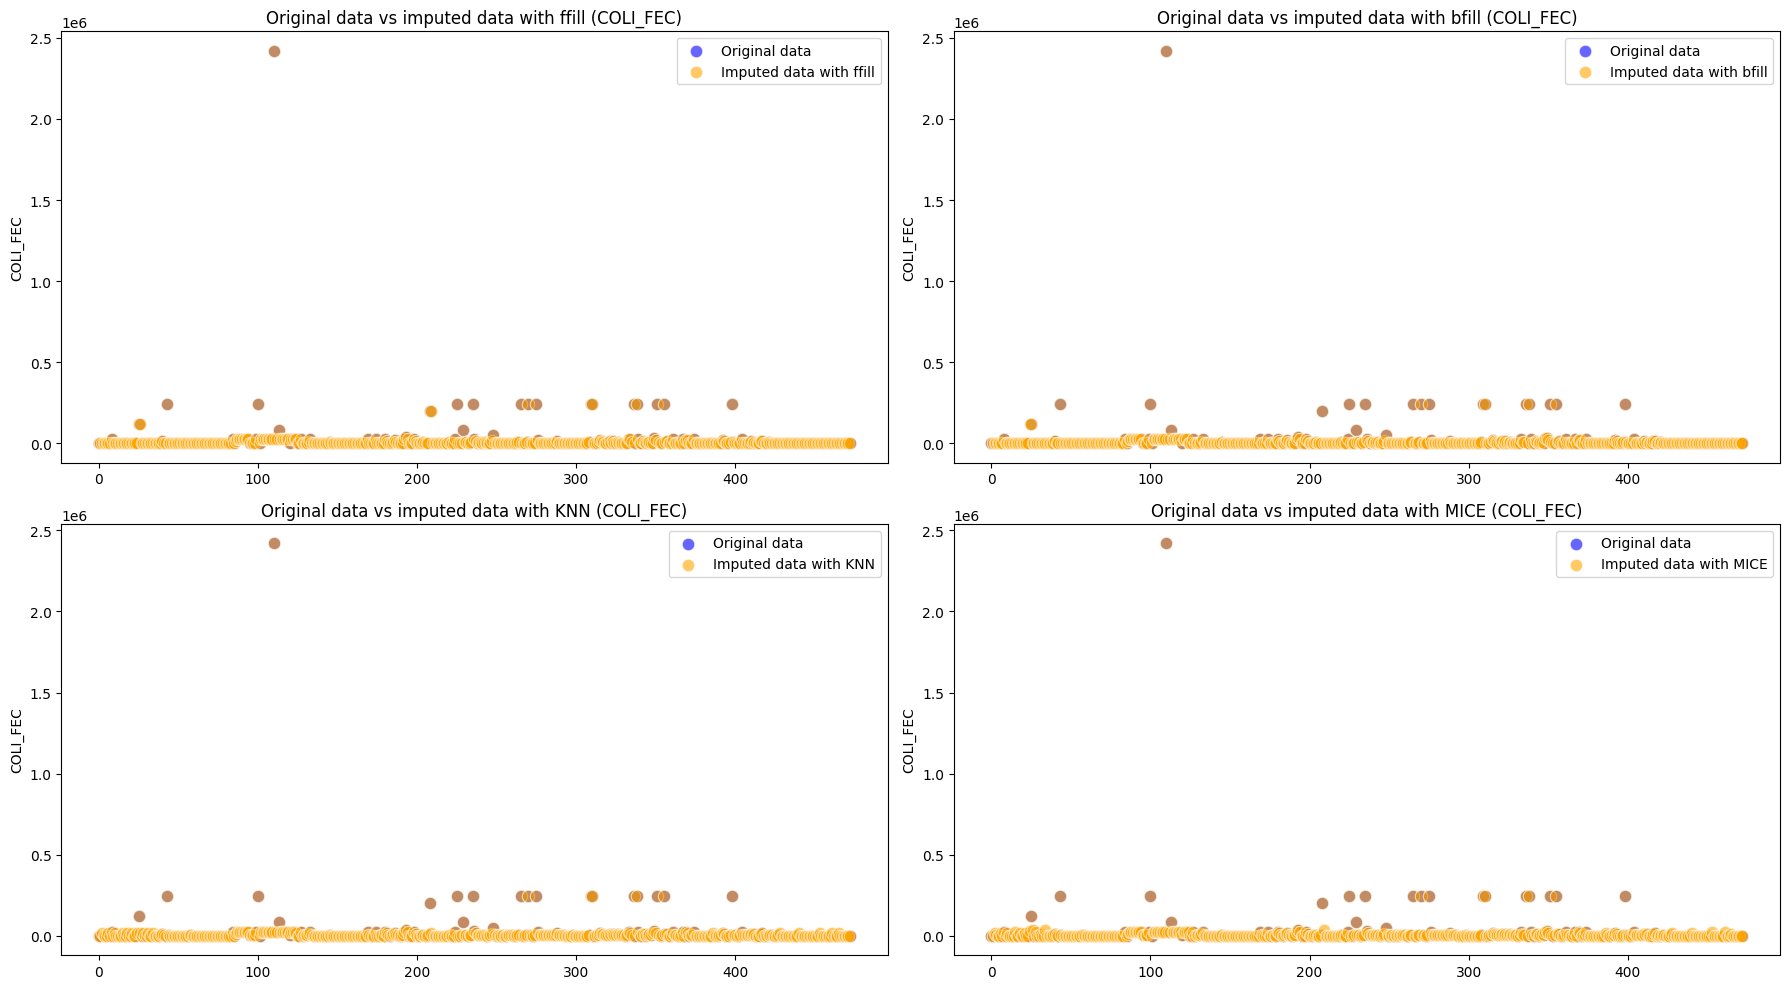

In [9]:
# Scatter graphs to compare the imputation methods for 'COLI_FEC and check for the occurrence of new potential outliers'
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Subplot 1: ffill method
sns.scatterplot(df_drop_water_sonora['COLI_FEC'], label='Original data', alpha=0.6, s=80, color='blue', ax=axes[0, 0])
sns.scatterplot(df_imputation_method['COLI_FEC_ffill'], label='Imputed data with ffill', alpha=0.6, s=80, color='orange', ax=axes[0, 0])
axes[0, 0].set_title('Original data vs imputed data with ffill (COLI_FEC)')
axes[0, 0].legend()

# Subplot 2: bfill method
sns.scatterplot(df_drop_water_sonora['COLI_FEC'], label='Original data', alpha=0.6, s=80, color='blue', ax=axes[0, 1])
sns.scatterplot(df_imputation_method['COLI_FEC_bfill'], label='Imputed data with bfill', alpha=0.6, s=80, color='orange', ax=axes[0, 1])
axes[0, 1].set_title('Original data vs imputed data with bfill (COLI_FEC)')
axes[0, 1].legend()

# Subplot 3: KNN method
sns.scatterplot(df_drop_water_sonora['COLI_FEC'], label='Original data', alpha=0.6, s=80, color='blue', ax=axes[1, 0])
sns.scatterplot(df_imputation_method['COLI_FEC_knn'], label='Imputed data with KNN', alpha=0.6, s=80, color='orange', ax=axes[1, 0])
axes[1, 0].set_title('Original data vs imputed data with KNN (COLI_FEC)')
axes[1, 0].legend()

# Subplot 4: MICE method
sns.scatterplot(df_drop_water_sonora['COLI_FEC'], label='Original data', alpha=0.6, s=80, color='blue', ax=axes[1, 1])
sns.scatterplot(df_imputation_method['COLI_FEC_mice'], label='Imputed data with MICE', alpha=0.6, s=80, color='orange', ax=axes[1, 1])
axes[1, 1].set_title('Original data vs imputed data with MICE (COLI_FEC)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

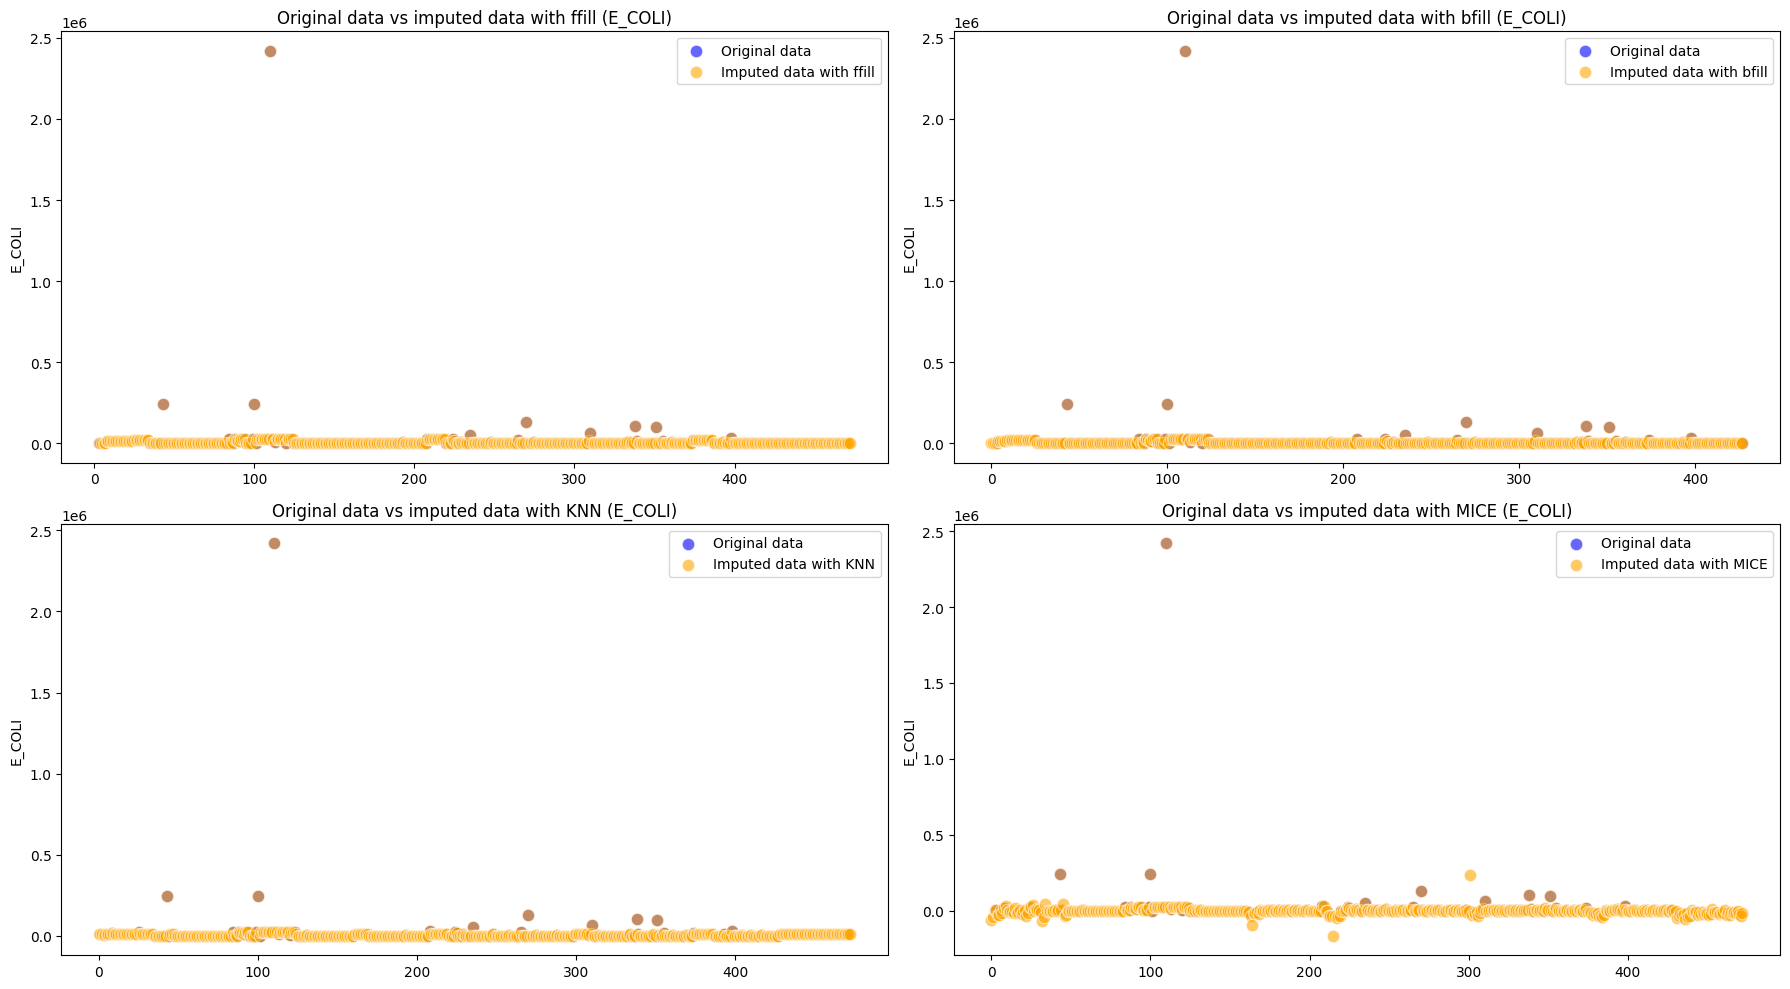

In [52]:
# Scatter graphs to compare the imputation methods for 'E_COLI and check for the occurrence of new potential outliers'
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Subplot 1: ffill method
sns.scatterplot(df_drop_water_sonora['E_COLI'], label='Original data', alpha=0.6, s=80, color='blue', ax=axes[0, 0])
sns.scatterplot(df_imputation_method['E_COLI_ffill'], label='Imputed data with ffill', alpha=0.6, s=80, color='orange', ax=axes[0, 0])
axes[0, 0].set_title('Original data vs imputed data with ffill (E_COLI)')
axes[0, 0].legend()

# Subplot 2: bfill method
sns.scatterplot(df_drop_water_sonora['E_COLI'], label='Original data', alpha=0.6, s=80, color='blue', ax=axes[0, 1])
sns.scatterplot(df_imputation_method['E_COLI_bfill'], label='Imputed data with bfill', alpha=0.6, s=80, color='orange', ax=axes[0, 1])
axes[0, 1].set_title('Original data vs imputed data with bfill (E_COLI)')
axes[0, 1].legend()

# Subplot 3: KNN method
sns.scatterplot(df_drop_water_sonora['E_COLI'], label='Original data', alpha=0.6, s=80, color='blue', ax=axes[1, 0])
sns.scatterplot(df_imputation_method['E_COLI_knn'], label='Imputed data with KNN', alpha=0.6, s=80, color='orange', ax=axes[1, 0])
axes[1, 0].set_title('Original data vs imputed data with KNN (E_COLI)')
axes[1, 0].legend()

# Subplot 4: MICE method
sns.scatterplot(df_drop_water_sonora['E_COLI'], label='Original data', alpha=0.6, s=80, color='blue', ax=axes[1, 1])
sns.scatterplot(df_imputation_method['E_COLI_mice'], label='Imputed data with MICE', alpha=0.6, s=80, color='orange', ax=axes[1, 1])
axes[1, 1].set_title('Original data vs imputed data with MICE (E_COLI)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

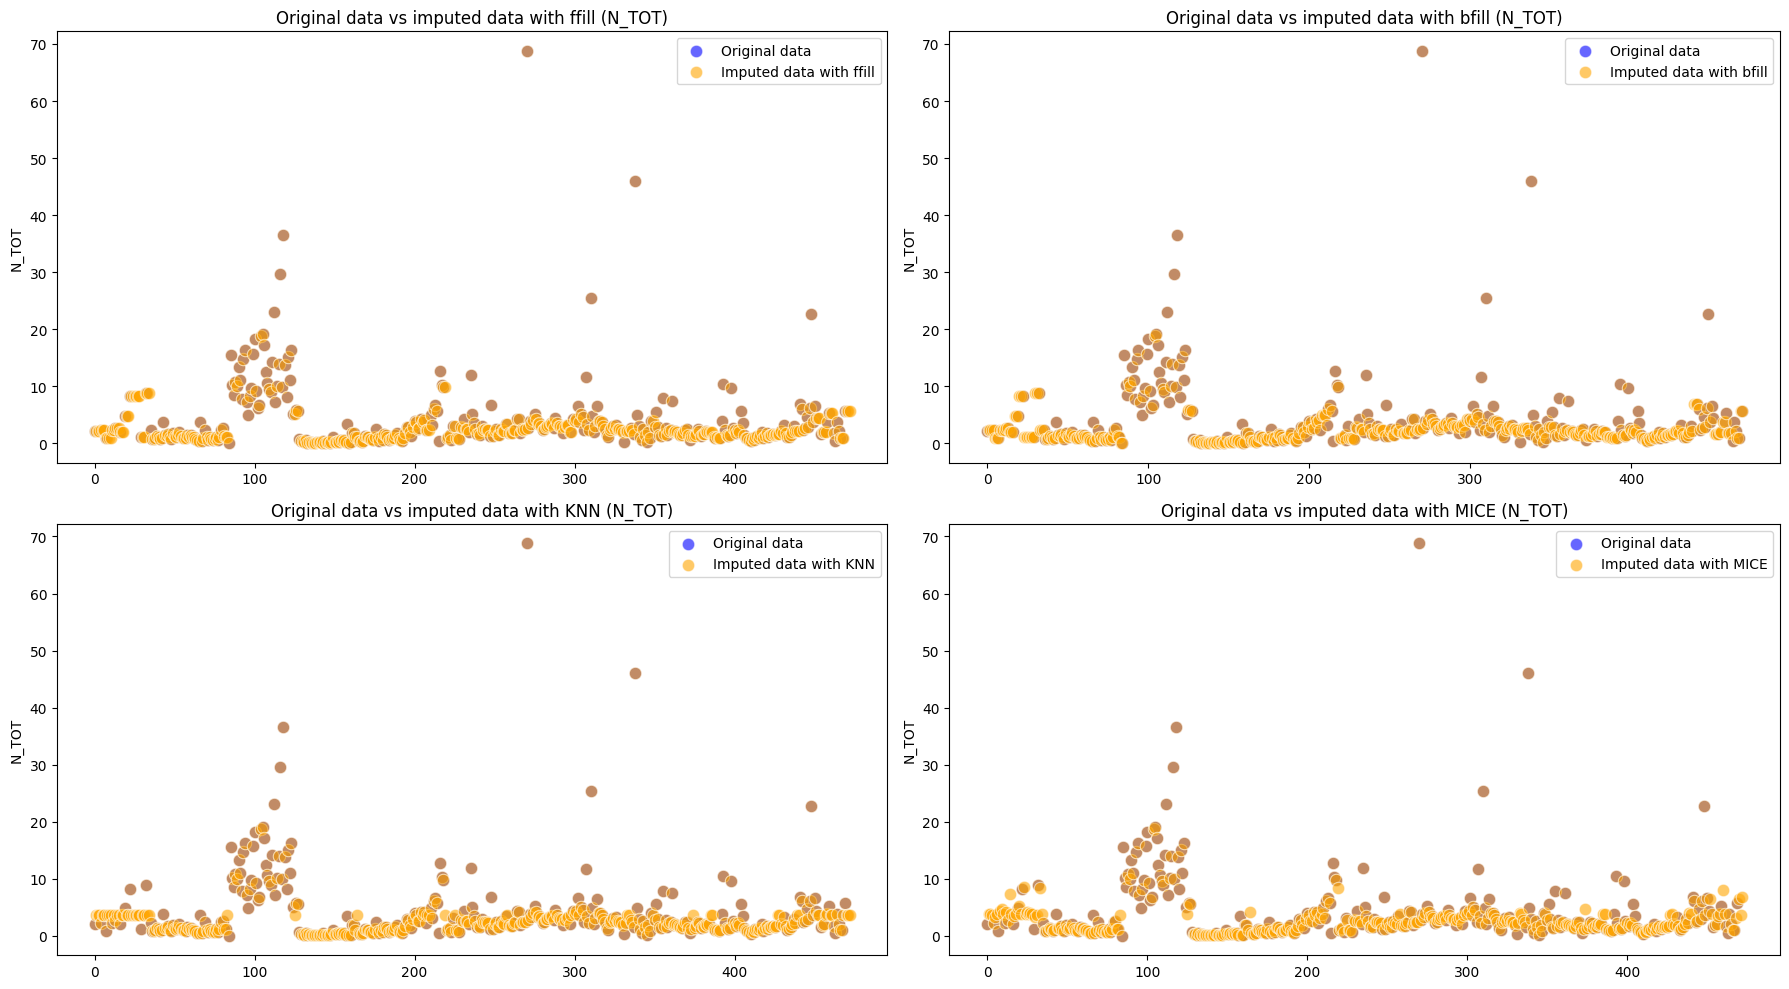

In [10]:
# Scatter graphs to compare the imputation methods for 'N_TOT and check for the occurrence of new potential outliers'
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Subplot 1: ffill method
sns.scatterplot(df_drop_water_sonora['N_TOT'], label='Original data', alpha=0.6, s=80, color='blue', ax=axes[0, 0])
sns.scatterplot(df_imputation_method['N_TOT_ffill'], label='Imputed data with ffill', alpha=0.6, s=80, color='orange', ax=axes[0, 0])
axes[0, 0].set_title('Original data vs imputed data with ffill (N_TOT)')
axes[0, 0].legend()

# Subplot 2: bfill method
sns.scatterplot(df_drop_water_sonora['N_TOT'], label='Original data', alpha=0.6, s=80, color='blue', ax=axes[0, 1])
sns.scatterplot(df_imputation_method['N_TOT_bfill'], label='Imputed data with bfill', alpha=0.6, s=80, color='orange', ax=axes[0, 1])
axes[0, 1].set_title('Original data vs imputed data with bfill (N_TOT)')
axes[0, 1].legend()

# Subplot 3: KNN method
sns.scatterplot(df_drop_water_sonora['N_TOT'], label='Original data', alpha=0.6, s=80, color='blue', ax=axes[1, 0])
sns.scatterplot(df_imputation_method['N_TOT_knn'], label='Imputed data with KNN', alpha=0.6, s=80, color='orange', ax=axes[1, 0])
axes[1, 0].set_title('Original data vs imputed data with KNN (N_TOT)')
axes[1, 0].legend()

# Subplot 4: MICE method
sns.scatterplot(df_drop_water_sonora['N_TOT'], label='Original data', alpha=0.6, s=80, color='blue', ax=axes[1, 1])
sns.scatterplot(df_imputation_method['N_TOT_mice'], label='Imputed data with MICE', alpha=0.6, s=80, color='orange', ax=axes[1, 1])
axes[1, 1].set_title('Original data vs imputed data with MICE (N_TOT)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [124]:
# Función para graficar los resultados de detección de outliers
def plot_outliers(df, column, estimates, title):

    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    # sns.set_style('whitegrid')

    # Minimum Covariance Determinant (MCD) robust
    ax1 = sns.scatterplot(
        x=range(len(df[column])),
        y=df[column], 
        hue=estimates['MCD'],
        palette='RdBu', 
        legend=False, 
        s=80, 
        ax=axes[0, 0]
    )
    # ax1.grid(False)
    norm1 = mpl.colors.Normalize(vmin=estimates['MCD'].min(), vmax=estimates['MCD'].max())
    sm1 = mpl.cm.ScalarMappable(cmap="RdBu", norm=norm1)
    sm1.set_array([])
    cax1 = fig.colorbar(sm1, ax=axes[0, 0], orientation="vertical", fraction=0.046, pad=0.04)
    axes[0, 0].set_title(f'Analysis of outliers using Minimum Covariance Determinant (MCD) {title}')
    axes[0, 0].set_ylabel('COLI_FEC')

    # Empirical Covariance (MLE) estimator
    ax2 = sns.scatterplot(
        x=range(len(df[column])),
        y=df[column], 
        hue=estimates['MLE'],
        palette='RdBu', 
        legend=False, 
        s=80, 
        ax=axes[0, 1]
    )
    # ax2.grid(True)
    norm2 = mpl.colors.Normalize(vmin=estimates['MLE'].min(), vmax=estimates['MLE'].max())
    sm2 = mpl.cm.ScalarMappable(cmap="RdBu", norm=norm2)
    sm2.set_array([])
    cax2 = fig.colorbar(sm2, ax=axes[0, 1], orientation="vertical", fraction=0.046, pad=0.04)
    axes[0, 1].set_title(f'Analysis of outliers using Empirical Covariance (MLE) {title}')
    axes[0, 1].set_ylabel('COLI_FEC')

    # Local Outlier Factor
    ax3 = sns.scatterplot(
        x=range(len(df[column])),
        y=df[column], 
        hue=estimates['LOF'],
        palette='RdBu', 
        legend=False, 
        s=80, 
        ax=axes[1, 0]
    )
    norm3 = mpl.colors.Normalize(vmin=estimates['LOF'].min(), vmax=estimates['LOF'].max())
    sm3 = mpl.cm.ScalarMappable(cmap="RdBu", norm=norm3)
    sm3.set_array([])
    cax3 = fig.colorbar(sm3, ax=axes[1, 0], orientation="vertical", fraction=0.046, pad=0.04)
    axes[1, 0].set_title(f'Analysis of outliers using Local Outlier Factor {title}')
    axes[1, 0].set_ylabel('COLI_FEC')

    # Isolation Forest estimator
    ax4 = sns.scatterplot(
        x=range(len(df[column])),
        y=df[column], 
        hue=estimates['IF'],
        palette='RdBu', 
        legend=False, 
        s=80, 
        ax=axes[1, 1]
    )
    norm4 = mpl.colors.Normalize(vmin=estimates['IF'].min(), vmax=estimates['IF'].max())
    sm4 = mpl.cm.ScalarMappable(cmap="RdBu", norm=norm4)
    sm4.set_array([])
    cax4 = fig.colorbar(sm4, ax=axes[1, 1], orientation="vertical", fraction=0.046, pad=0.04)
    axes[1, 1].set_title(f'Analysis of outliers using Isolation Forest {title}')
    axes[1, 1].set_ylabel('COLI_FEC')

    plt.tight_layout()
    plt.show()

In [120]:
def outlier_detection(df, column, plot=True):
    
    # Treatment of outliers for COLI_FEC using various method of outlier detection (ffill)
    
    df_column = df[[column]]

    # Minimum Covariance Determinant (MCD) robust estimator
    robust_cov = MinCovDet().fit(df_column)
    estimate_MCD = robust_cov.mahalanobis(df_column)

    # Empirical Covariance (MLE) estimator
    emp_cov = EmpiricalCovariance().fit(df_column)
    estimate_MLE = emp_cov.mahalanobis(df_column)

    # Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=100)
    estimate_LOF = lof.fit_predict(df_column)

    # Isolation Forest estimator
    iso_forest = IsolationForest(
        contamination=0.01, 
        n_estimators=100, 
        warm_start=True
    ).fit(df_column)
    estimate_IF = iso_forest.predict(df_column)

    estimates = {
        "MCD": estimate_MCD,
        "MLE": estimate_MLE,
        "LOF": estimate_LOF,
        "IF": estimate_IF
    }

    if plot:
        plot_outliers(df, column, estimates, title='in imputed data with ffill')

    return estimates

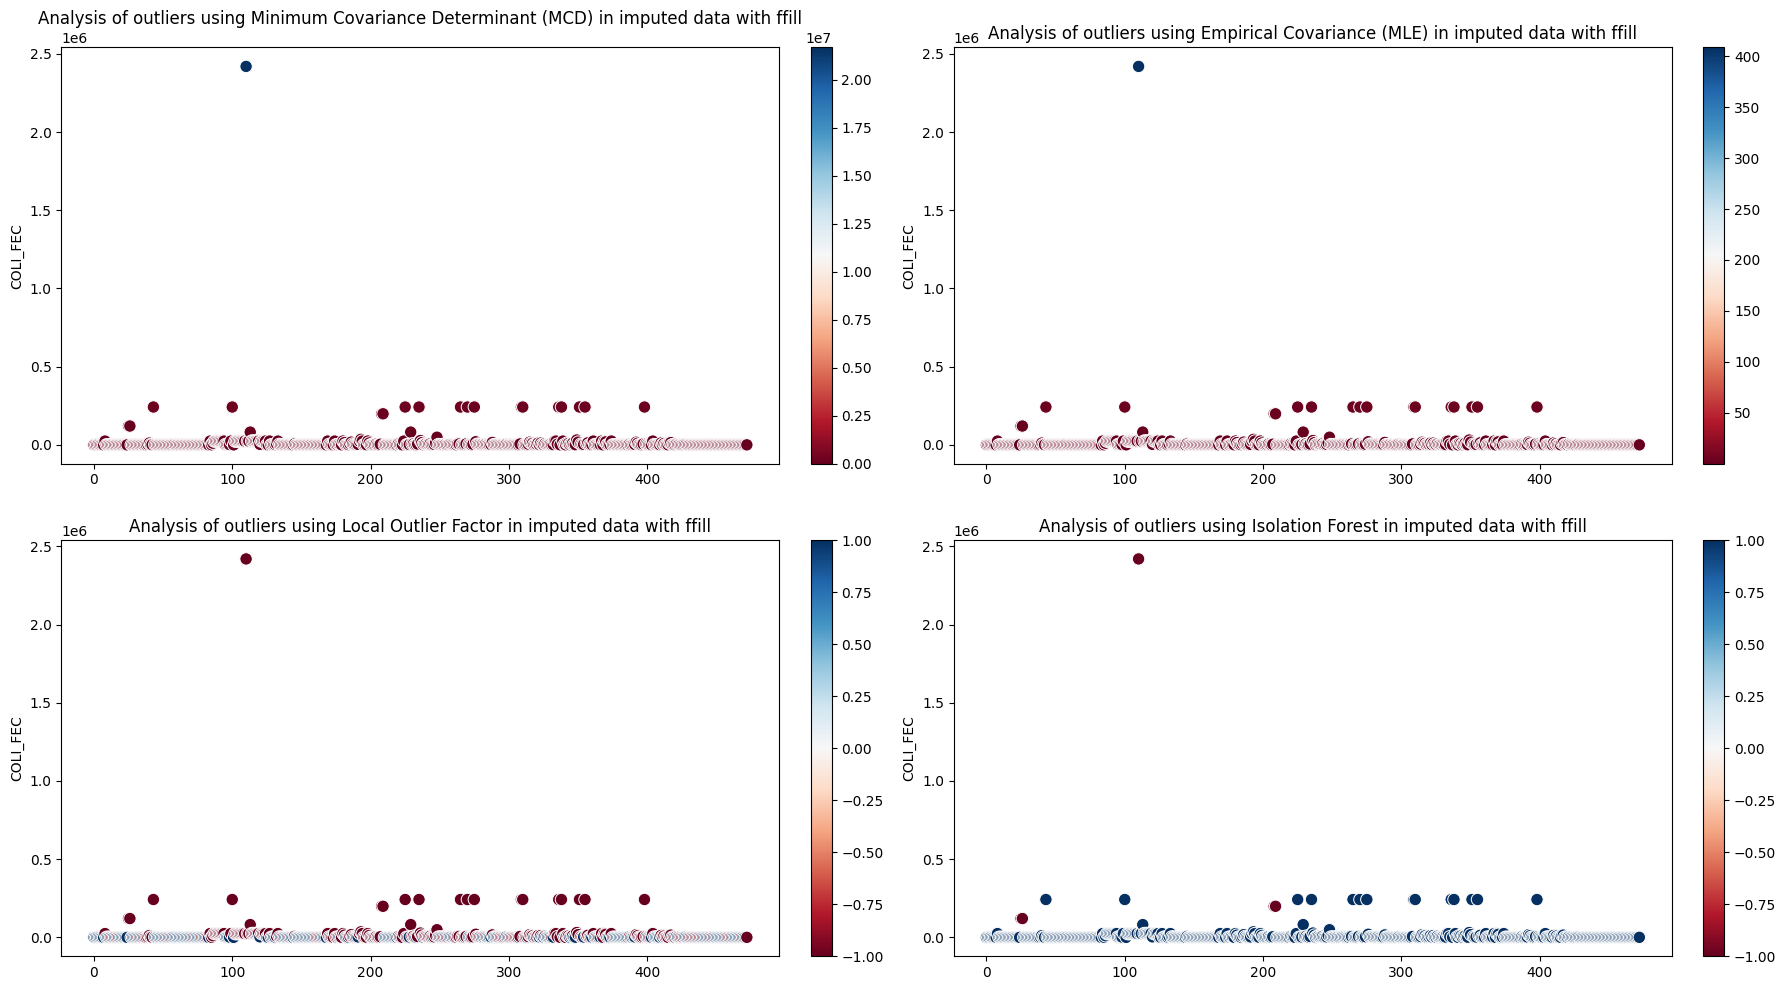

{'MCD': array([4.32201446e-01, 4.32201446e-01, 4.32201446e-01, 6.32418267e+00,
        4.32201446e-01, 4.32201446e-01, 4.32201446e-01, 4.32201446e-01,
        2.10661596e+03, 4.32201446e-01, 4.32201446e-01, 4.32201446e-01,
        3.57303643e-01, 3.57303643e-01, 4.32201446e-01, 4.32201446e-01,
        4.07262775e-01, 1.56527625e-01, 1.56527625e-01, 4.32201446e-01,
        4.32201446e-01, 4.32201446e-01, 4.32201446e-01, 4.32201446e-01,
        4.32201446e-01, 5.33355614e+04, 5.33355614e+04, 4.32201446e-01,
        4.32201446e-01, 4.32201446e-01, 4.32201446e-01, 4.32201446e-01,
        2.17955016e-01, 4.32201446e-01, 4.32201446e-01, 1.58054438e-01,
        4.50099433e-01, 2.16161429e-01, 2.16161429e-01, 3.55256497e+01,
        4.35980059e+02, 8.43100827e+00, 6.15157460e-01, 2.16289068e+05,
        6.38240435e+00, 4.32201446e-01, 4.32201446e-01, 4.32201446e-01,
        4.50099433e-01, 4.50099433e-01, 4.55279837e-01, 4.55279837e-01,
        4.55279837e-01, 2.16161429e-01, 4.55279837e-01, 4

In [125]:
outlier_detection(df_imputation_method, 'COLI_FEC_ffill')

In [169]:
# estimate_MCD

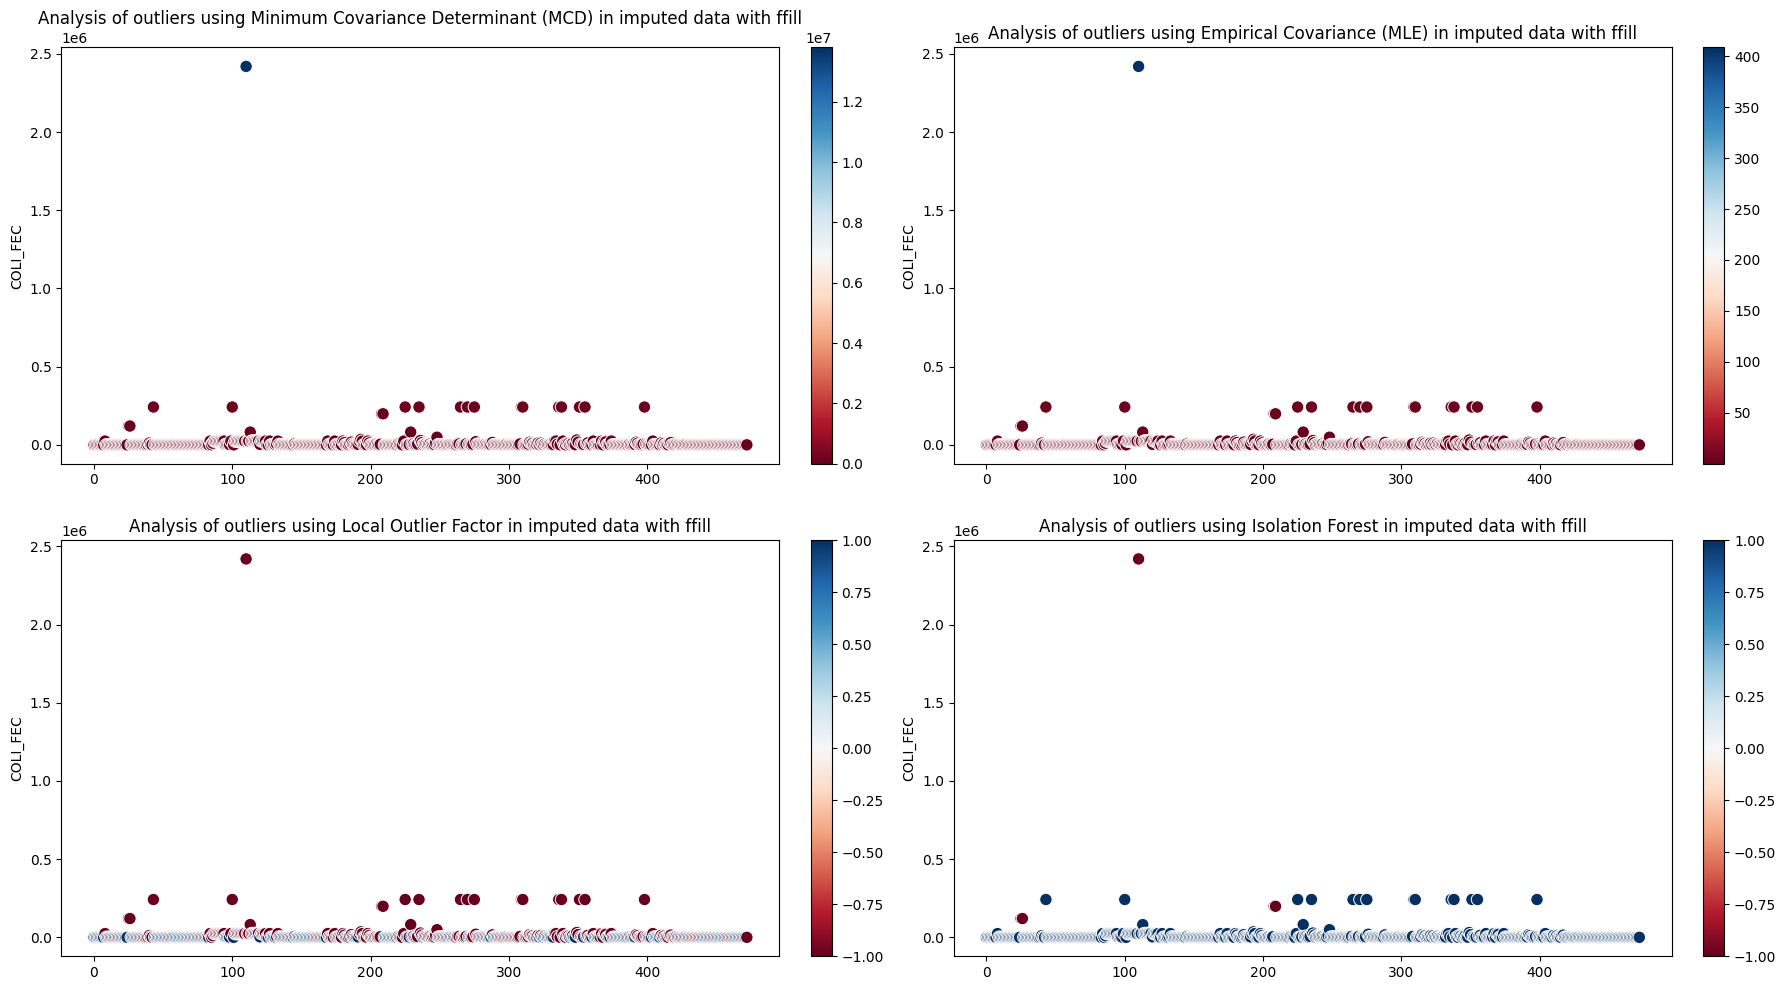

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
# sns.set_style('whitegrid')

# Minimum Covariance Determinant (MCD) robust
ax1 = sns.scatterplot(
    x=range(len(df_imputation_method['COLI_FEC_ffill'])),
    y=df_imputation_method['COLI_FEC_ffill'], 
    hue=estimate_MCD,
    palette='RdBu', 
    legend=False, 
    s=80, 
    ax=axes[0, 0]
)
# ax1.grid(False)
norm1 = mpl.colors.Normalize(vmin=estimate_MCD.min(), vmax=estimate_MCD.max())
sm1 = mpl.cm.ScalarMappable(cmap="RdBu", norm=norm1)
sm1.set_array([])
cax1 = fig.colorbar(sm1, ax=axes[0, 0], orientation="vertical", fraction=0.046, pad=0.04)
axes[0, 0].set_title('Analysis of outliers using Minimum Covariance Determinant (MCD) in imputed data with ffill')
axes[0, 0].set_ylabel('COLI_FEC')

# Empirical Covariance (MLE) estimator
ax2 = sns.scatterplot(
    x=range(len(df_imputation_method['COLI_FEC_ffill'])),
    y=df_imputation_method['COLI_FEC_ffill'], 
    hue=estimate_MLE_COLI_FEC_ffill,
    palette='RdBu', 
    legend=False, 
    s=80, 
    ax=axes[0, 1]
)
# ax2.grid(True)
norm2 = mpl.colors.Normalize(vmin=estimate_MLE_COLI_FEC_ffill.min(), vmax=estimate_MLE_COLI_FEC_ffill.max())
sm2 = mpl.cm.ScalarMappable(cmap="RdBu", norm=norm2)
sm2.set_array([])
cax2 = fig.colorbar(sm2, ax=axes[0, 1], orientation="vertical", fraction=0.046, pad=0.04)
axes[0, 1].set_title('Analysis of outliers using Empirical Covariance (MLE) in imputed data with ffill')
axes[0, 1].set_ylabel('COLI_FEC')

# Local Outlier Factor
ax3 = sns.scatterplot(
    x=range(len(df_imputation_method['COLI_FEC_ffill'])),
    y=df_imputation_method['COLI_FEC_ffill'], 
    hue=estimate_LOF_COLI_FEC_ffill,
    palette='RdBu', 
    legend=False, 
    s=80, 
    ax=axes[1, 0]
)
norm3 = mpl.colors.Normalize(vmin=estimate_LOF_COLI_FEC_ffill.min(), vmax=estimate_LOF_COLI_FEC_ffill.max())
sm3 = mpl.cm.ScalarMappable(cmap="RdBu", norm=norm3)
sm3.set_array([])
cax3 = fig.colorbar(sm3, ax=axes[1, 0], orientation="vertical", fraction=0.046, pad=0.04)
axes[1, 0].set_title('Analysis of outliers using Local Outlier Factor in imputed data with ffill')
axes[1, 0].set_ylabel('COLI_FEC')

# Isolation Forest estimator
ax4 = sns.scatterplot(
    x=range(len(df_imputation_method['COLI_FEC_ffill'])),
    y=df_imputation_method['COLI_FEC_ffill'], 
    hue=estimate_IF_COLI_FEC_ffill,
    palette='RdBu', 
    legend=False, 
    s=80, 
    ax=axes[1, 1]
)
norm4 = mpl.colors.Normalize(vmin=estimate_IF_COLI_FEC_ffill.min(), vmax=estimate_IF_COLI_FEC_ffill.max())
sm4 = mpl.cm.ScalarMappable(cmap="RdBu", norm=norm4)
sm4.set_array([])
cax4 = fig.colorbar(sm4, ax=axes[1, 1], orientation="vertical", fraction=0.046, pad=0.04)
axes[1, 1].set_title('Analysis of outliers using Isolation Forest in imputed data with ffill')
axes[1, 1].set_ylabel('COLI_FEC')

plt.tight_layout()
plt.show()

In [34]:
# Treatment of outliers for COLI_FEC using various method of outlier detection (bfill)

COLI_FEC_bfill = df_imputation_method[['COLI_FEC_bfill']]

# Minimum Covariance Determinant (MCD) robust estimator
robust_cov_COLI_FEC_bfill = MinCovDet().fit(COLI_FEC_bfill)
estimate_MCD = robust_cov_COLI_FEC_bfill.mahalanobis(COLI_FEC_bfill)

# Empirical Covariance (MLE) estimator
emp_cov_COLI_FEC_bfill = EmpiricalCovariance().fit(COLI_FEC_bfill)
estimate_MLE_COLI_FEC_bfill = emp_cov_COLI_FEC_bfill.mahalanobis(COLI_FEC_bfill)

# Local Outlier Factor
clf_COLI_FEC_bfill = LocalOutlierFactor(n_neighbors=100)
estimate_LOF_COLI_FEC_bfill = clf_COLI_FEC_bfill.fit_predict(COLI_FEC_bfill)

# Isolation Forest estimator
iso_forest_COLI_FEC_bfill = IsolationForest(
    contamination=0.01, 
    n_estimators=100, 
    warm_start=True
).fit(COLI_FEC_bfill)
estimate_IF_COLI_FEC_bfill = iso_forest_COLI_FEC_bfill.predict(COLI_FEC_bfill)

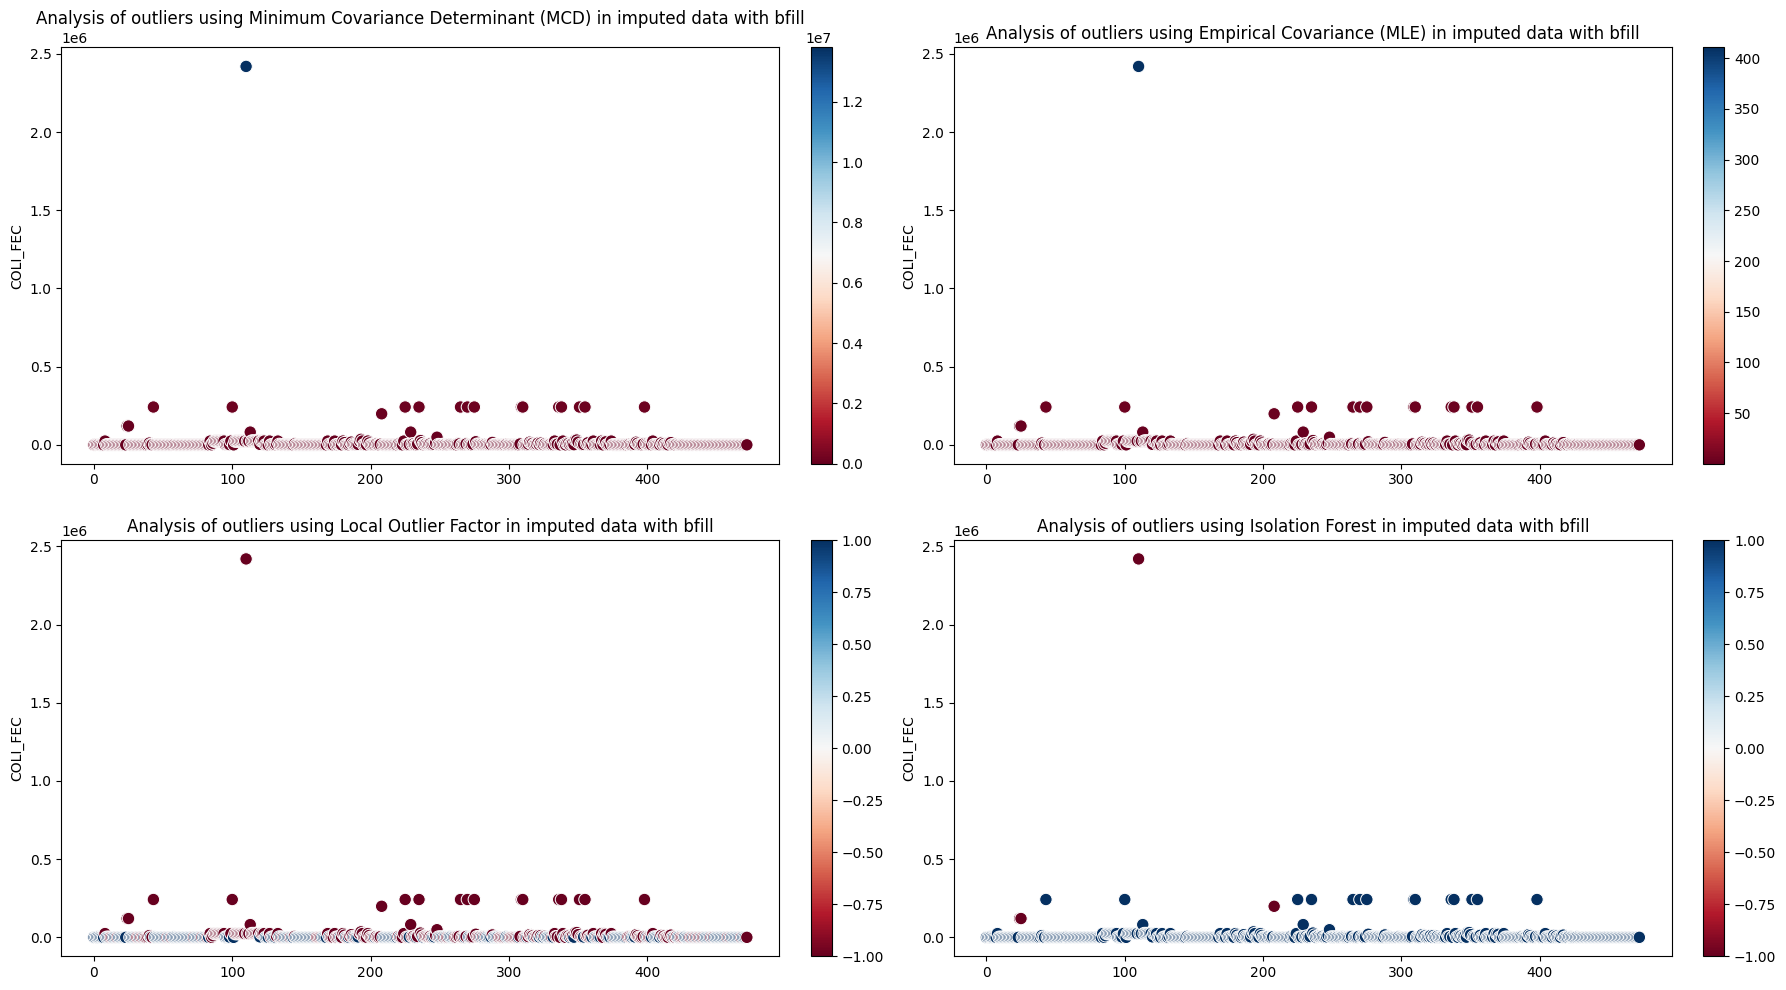

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
# sns.set_style('whitegrid')

# Minimum Covariance Determinant (MCD) robust
ax1 = sns.scatterplot(
    x=range(len(df_imputation_method['COLI_FEC_bfill'])),
    y=df_imputation_method['COLI_FEC_bfill'], 
    hue=estimate_MCD,
    palette='RdBu', 
    legend=False, 
    s=80, 
    ax=axes[0, 0]
)
# ax1.grid(False)
norm1 = mpl.colors.Normalize(vmin=estimate_MCD.min(), vmax=estimate_MCD.max())
sm1 = mpl.cm.ScalarMappable(cmap="RdBu", norm=norm1)
sm1.set_array([])
cax1 = fig.colorbar(sm1, ax=axes[0, 0], orientation="vertical", fraction=0.046, pad=0.04)
axes[0, 0].set_title('Analysis of outliers using Minimum Covariance Determinant (MCD) in imputed data with bfill')
axes[0, 0].set_ylabel('COLI_FEC')

# Empirical Covariance (MLE) estimator
ax2 = sns.scatterplot(
    x=range(len(df_imputation_method['COLI_FEC_bfill'])),
    y=df_imputation_method['COLI_FEC_bfill'], 
    hue=estimate_MLE_COLI_FEC_bfill,
    palette='RdBu', 
    legend=False, 
    s=80, 
    ax=axes[0, 1]
)
# ax2.grid(True)
norm2 = mpl.colors.Normalize(vmin=estimate_MLE_COLI_FEC_bfill.min(), vmax=estimate_MLE_COLI_FEC_bfill.max())
sm2 = mpl.cm.ScalarMappable(cmap="RdBu", norm=norm2)
sm2.set_array([])
cax2 = fig.colorbar(sm2, ax=axes[0, 1], orientation="vertical", fraction=0.046, pad=0.04)
axes[0, 1].set_title('Analysis of outliers using Empirical Covariance (MLE) in imputed data with bfill')
axes[0, 1].set_ylabel('COLI_FEC')

# Local Outlier Factor
ax3 = sns.scatterplot(
    x=range(len(df_imputation_method['COLI_FEC_bfill'])),
    y=df_imputation_method['COLI_FEC_bfill'], 
    hue=estimate_LOF_COLI_FEC_bfill,
    palette='RdBu', 
    legend=False, 
    s=80, 
    ax=axes[1, 0]
)
norm3 = mpl.colors.Normalize(vmin=estimate_LOF_COLI_FEC_bfill.min(), vmax=estimate_LOF_COLI_FEC_bfill.max())
sm3 = mpl.cm.ScalarMappable(cmap="RdBu", norm=norm3)
sm3.set_array([])
cax3 = fig.colorbar(sm3, ax=axes[1, 0], orientation="vertical", fraction=0.046, pad=0.04)
axes[1, 0].set_title('Analysis of outliers using Local Outlier Factor in imputed data with bfill')
axes[1, 0].set_ylabel('COLI_FEC')

# Isolation Forest estimator
ax4 = sns.scatterplot(
    x=range(len(df_imputation_method['COLI_FEC_bfill'])),
    y=df_imputation_method['COLI_FEC_bfill'], 
    hue=estimate_IF_COLI_FEC_bfill,
    palette='RdBu', 
    legend=False, 
    s=80, 
    ax=axes[1, 1]
)
norm4 = mpl.colors.Normalize(vmin=estimate_IF_COLI_FEC_bfill.min(), vmax=estimate_IF_COLI_FEC_bfill.max())
sm4 = mpl.cm.ScalarMappable(cmap="RdBu", norm=norm4)
sm4.set_array([])
cax4 = fig.colorbar(sm4, ax=axes[1, 1], orientation="vertical", fraction=0.046, pad=0.04)
axes[1, 1].set_title('Analysis of outliers using Isolation Forest in imputed data with bfill')
axes[1, 1].set_ylabel('COLI_FEC')

plt.tight_layout()
plt.show()

In [35]:
# Treatment of outliers for COLI_FEC using various method of outlier detection (knn)

COLI_FEC_knn = df_imputation_method[['COLI_FEC_knn']]

# Minimum Covariance Determinant (MCD) robust estimator
robust_cov_COLI_FEC_knn = MinCovDet().fit(COLI_FEC_knn)
estimate_MCD = robust_cov_COLI_FEC_knn.mahalanobis(COLI_FEC_knn)

# Empirical Covariance (MLE) estimator
emp_cov_COLI_FEC_knn = EmpiricalCovariance().fit(COLI_FEC_knn)
estimate_MLE_COLI_FEC_knn = emp_cov_COLI_FEC_knn.mahalanobis(COLI_FEC_knn)

# Local Outlier Factor
clf_COLI_FEC_knn = LocalOutlierFactor(n_neighbors=100)
estimate_LOF_COLI_FEC_knn = clf_COLI_FEC_knn.fit_predict(COLI_FEC_knn)

# Isolation Forest estimator
iso_forest_COLI_FEC_knn = IsolationForest(
    contamination=0.01, 
    n_estimators=100, 
    warm_start=True
).fit(COLI_FEC_knn)
estimate_IF_COLI_FEC_knn = iso_forest_COLI_FEC_knn.predict(COLI_FEC_knn)

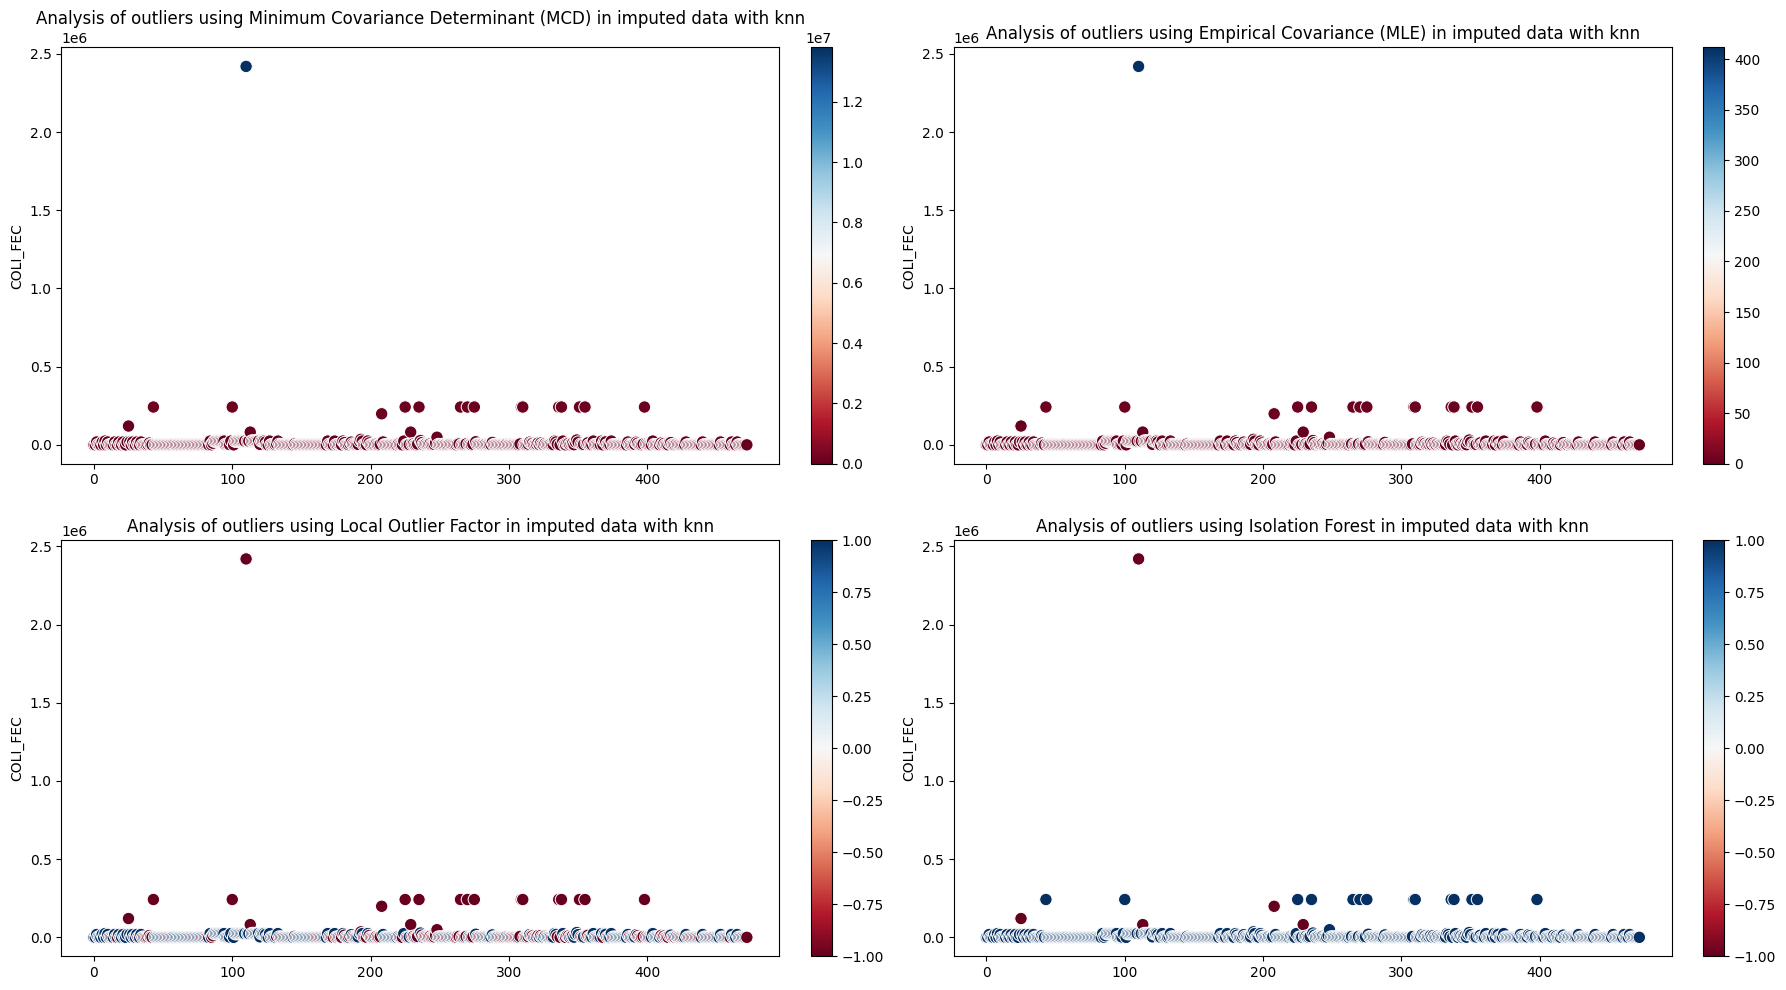

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
# sns.set_style('whitegrid')

# Minimum Covariance Determinant (MCD) robust
ax1 = sns.scatterplot(
    x=range(len(df_imputation_method['COLI_FEC_knn'])),
    y=df_imputation_method['COLI_FEC_knn'], 
    hue=estimate_MCD,
    palette='RdBu', 
    legend=False, 
    s=80, 
    ax=axes[0, 0]
)
# ax1.grid(False)
norm1 = mpl.colors.Normalize(vmin=estimate_MCD.min(), vmax=estimate_MCD.max())
sm1 = mpl.cm.ScalarMappable(cmap="RdBu", norm=norm1)
sm1.set_array([])
cax1 = fig.colorbar(sm1, ax=axes[0, 0], orientation="vertical", fraction=0.046, pad=0.04)
axes[0, 0].set_title('Analysis of outliers using Minimum Covariance Determinant (MCD) in imputed data with knn')
axes[0, 0].set_ylabel('COLI_FEC')

# Empirical Covariance (MLE) estimator
ax2 = sns.scatterplot(
    x=range(len(df_imputation_method['COLI_FEC_knn'])),
    y=df_imputation_method['COLI_FEC_knn'], 
    hue=estimate_MLE_COLI_FEC_knn,
    palette='RdBu', 
    legend=False, 
    s=80, 
    ax=axes[0, 1]
)
# ax2.grid(True)
norm2 = mpl.colors.Normalize(vmin=estimate_MLE_COLI_FEC_knn.min(), vmax=estimate_MLE_COLI_FEC_knn.max())
sm2 = mpl.cm.ScalarMappable(cmap="RdBu", norm=norm2)
sm2.set_array([])
cax2 = fig.colorbar(sm2, ax=axes[0, 1], orientation="vertical", fraction=0.046, pad=0.04)
axes[0, 1].set_title('Analysis of outliers using Empirical Covariance (MLE) in imputed data with knn')
axes[0, 1].set_ylabel('COLI_FEC')

# Local Outlier Factor
ax3 = sns.scatterplot(
    x=range(len(df_imputation_method['COLI_FEC_knn'])),
    y=df_imputation_method['COLI_FEC_knn'], 
    hue=estimate_LOF_COLI_FEC_knn,
    palette='RdBu', 
    legend=False, 
    s=80, 
    ax=axes[1, 0]
)
norm3 = mpl.colors.Normalize(vmin=estimate_LOF_COLI_FEC_knn.min(), vmax=estimate_LOF_COLI_FEC_knn.max())
sm3 = mpl.cm.ScalarMappable(cmap="RdBu", norm=norm3)
sm3.set_array([])
cax3 = fig.colorbar(sm3, ax=axes[1, 0], orientation="vertical", fraction=0.046, pad=0.04)
axes[1, 0].set_title('Analysis of outliers using Local Outlier Factor in imputed data with knn')
axes[1, 0].set_ylabel('COLI_FEC')

# Isolation Forest estimator
ax4 = sns.scatterplot(
    x=range(len(df_imputation_method['COLI_FEC_knn'])),
    y=df_imputation_method['COLI_FEC_knn'], 
    hue=estimate_IF_COLI_FEC_knn,
    palette='RdBu', 
    legend=False, 
    s=80, 
    ax=axes[1, 1]
)
norm4 = mpl.colors.Normalize(vmin=estimate_IF_COLI_FEC_knn.min(), vmax=estimate_IF_COLI_FEC_knn.max())
sm4 = mpl.cm.ScalarMappable(cmap="RdBu", norm=norm4)
sm4.set_array([])
cax4 = fig.colorbar(sm4, ax=axes[1, 1], orientation="vertical", fraction=0.046, pad=0.04)
axes[1, 1].set_title('Analysis of outliers using Isolation Forest in imputed data with knn')
axes[1, 1].set_ylabel('COLI_FEC')

plt.tight_layout()
plt.show()

In [36]:
# Treatment of outliers for COLI_FEC using various method of outlier detection

COLI_FEC_mice = df_imputation_method[['COLI_FEC_mice']]

# Minimum Covariance Determinant (MCD) robust estimator
robust_cov_COLI_FEC_mice = MinCovDet().fit(COLI_FEC_mice)
estimate_MCD = robust_cov_COLI_FEC_mice.mahalanobis(COLI_FEC_mice)

# Empirical Covariance (MLE) estimator
emp_cov_COLI_FEC_mice = EmpiricalCovariance().fit(COLI_FEC_mice)
estimate_MLE_COLI_FEC_mice = emp_cov_COLI_FEC_mice.mahalanobis(COLI_FEC_mice)

# Local Outlier Factor
clf_COLI_FEC_mice = LocalOutlierFactor(n_neighbors=100)
estimate_LOF_COLI_FEC_mice = clf_COLI_FEC_mice.fit_predict(COLI_FEC_mice)

# Isolation Forest estimator
iso_forest_COLI_FEC_mice = IsolationForest(
    contamination=0.01, 
    n_estimators=100, 
    warm_start=True
).fit(COLI_FEC_mice)
estimate_IF_COLI_FEC_mice = iso_forest_COLI_FEC_mice.predict(COLI_FEC_mice)

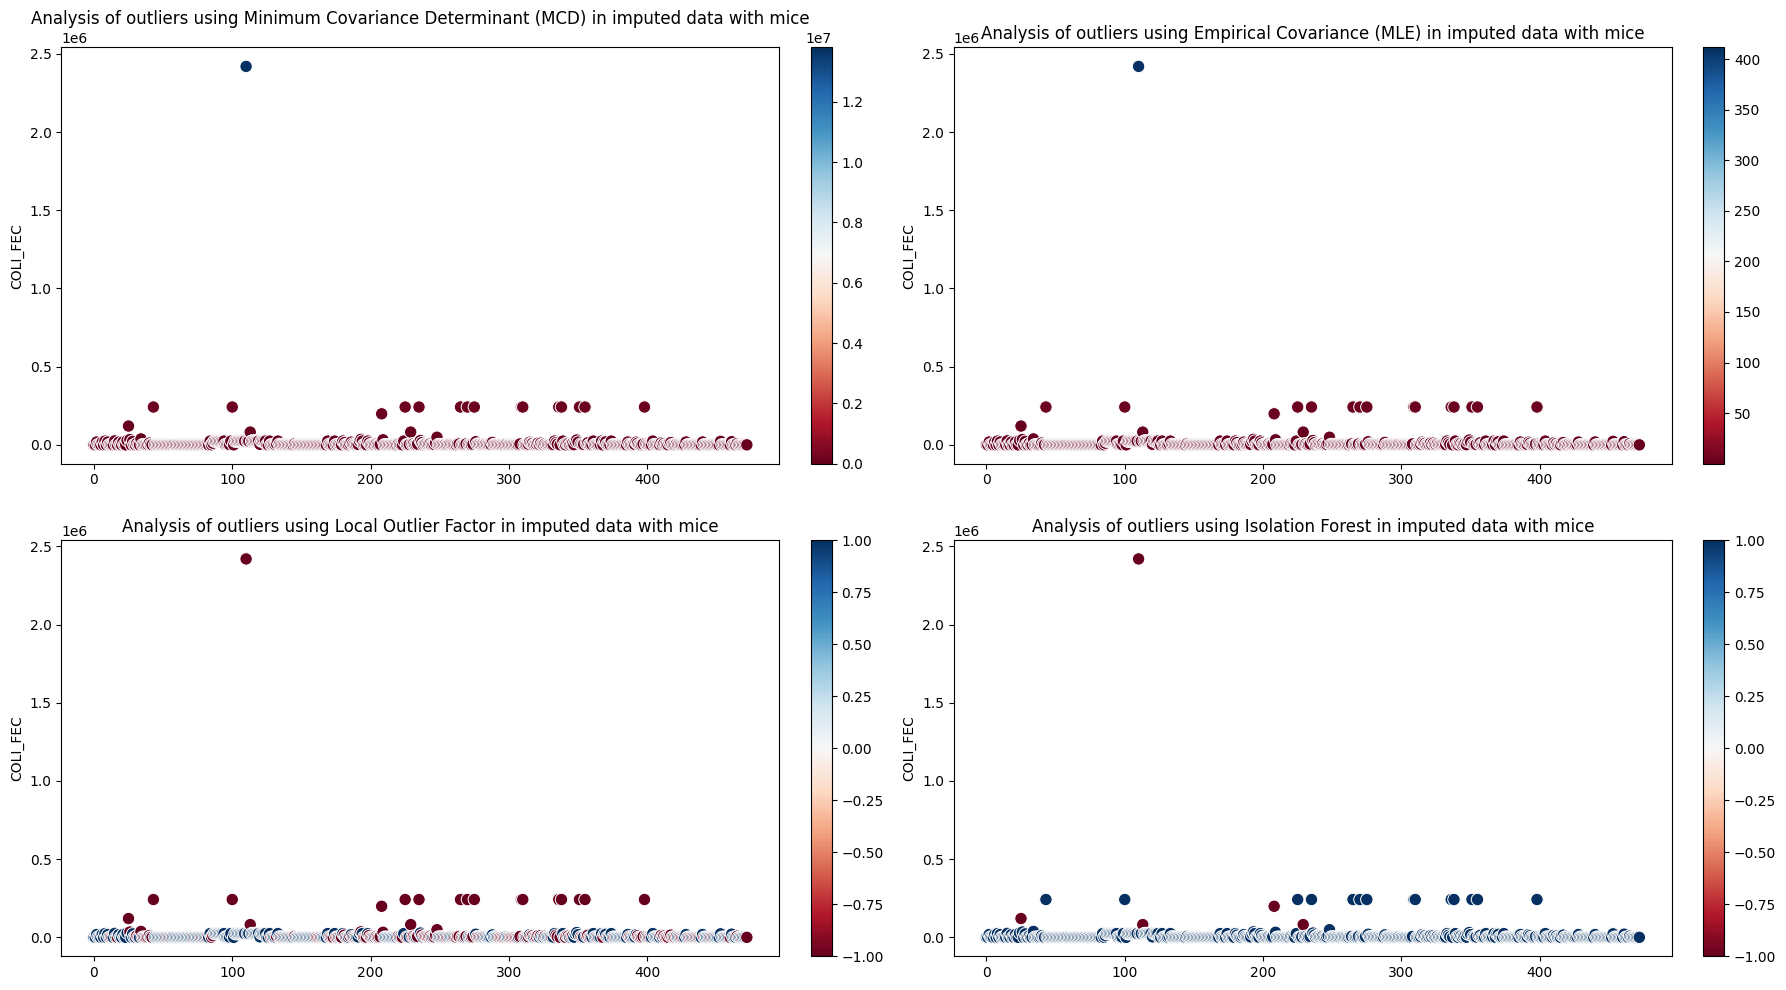

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
# sns.set_style('whitegrid')

# Minimum Covariance Determinant (MCD) robust
ax1 = sns.scatterplot(
    x=range(len(df_imputation_method['COLI_FEC_mice'])),
    y=df_imputation_method['COLI_FEC_mice'], 
    hue=estimate_MCD,
    palette='RdBu', 
    legend=False, 
    s=80, 
    ax=axes[0, 0]
)
# ax1.grid(False)
norm1 = mpl.colors.Normalize(vmin=estimate_MCD.min(), vmax=estimate_MCD.max())
sm1 = mpl.cm.ScalarMappable(cmap="RdBu", norm=norm1)
sm1.set_array([])
cax1 = fig.colorbar(sm1, ax=axes[0, 0], orientation="vertical", fraction=0.046, pad=0.04)
axes[0, 0].set_title('Analysis of outliers using Minimum Covariance Determinant (MCD) in imputed data with mice')
axes[0, 0].set_ylabel('COLI_FEC')

# Empirical Covariance (MLE) estimator
ax2 = sns.scatterplot(
    x=range(len(df_imputation_method['COLI_FEC_mice'])),
    y=df_imputation_method['COLI_FEC_mice'], 
    hue=estimate_MLE_COLI_FEC_mice,
    palette='RdBu', 
    legend=False, 
    s=80, 
    ax=axes[0, 1]
)
# ax2.grid(True)
norm2 = mpl.colors.Normalize(vmin=estimate_MLE_COLI_FEC_mice.min(), vmax=estimate_MLE_COLI_FEC_mice.max())
sm2 = mpl.cm.ScalarMappable(cmap="RdBu", norm=norm2)
sm2.set_array([])
cax2 = fig.colorbar(sm2, ax=axes[0, 1], orientation="vertical", fraction=0.046, pad=0.04)
axes[0, 1].set_title('Analysis of outliers using Empirical Covariance (MLE) in imputed data with mice')
axes[0, 1].set_ylabel('COLI_FEC')

# Local Outlier Factor
ax3 = sns.scatterplot(
    x=range(len(df_imputation_method['COLI_FEC_mice'])),
    y=df_imputation_method['COLI_FEC_mice'], 
    hue=estimate_LOF_COLI_FEC_mice,
    palette='RdBu', 
    legend=False, 
    s=80, 
    ax=axes[1, 0]
)
norm3 = mpl.colors.Normalize(vmin=estimate_LOF_COLI_FEC_mice.min(), vmax=estimate_LOF_COLI_FEC_mice.max())
sm3 = mpl.cm.ScalarMappable(cmap="RdBu", norm=norm3)
sm3.set_array([])
cax3 = fig.colorbar(sm3, ax=axes[1, 0], orientation="vertical", fraction=0.046, pad=0.04)
axes[1, 0].set_title('Analysis of outliers using Local Outlier Factor in imputed data with mice')
axes[1, 0].set_ylabel('COLI_FEC')

# Isolation Forest estimator
ax4 = sns.scatterplot(
    x=range(len(df_imputation_method['COLI_FEC_mice'])),
    y=df_imputation_method['COLI_FEC_mice'], 
    hue=estimate_IF_COLI_FEC_mice,
    palette='RdBu', 
    legend=False, 
    s=80, 
    ax=axes[1, 1]
)
norm4 = mpl.colors.Normalize(vmin=estimate_IF_COLI_FEC_mice.min(), vmax=estimate_IF_COLI_FEC_mice.max())
sm4 = mpl.cm.ScalarMappable(cmap="RdBu", norm=norm4)
sm4.set_array([])
cax4 = fig.colorbar(sm4, ax=axes[1, 1], orientation="vertical", fraction=0.046, pad=0.04)
axes[1, 1].set_title('Analysis of outliers using Isolation Forest in imputed data with mice')
axes[1, 1].set_ylabel('COLI_FEC')

plt.tight_layout()
plt.show()

In [16]:
E_COLI_ffill.isnull().sum()

E_COLI_ffill    3
dtype: int64

In [ ]:
pd.merge(df_imputation_method['COLI_FEC_mice'], df_imputation_method['COLI_FEC_knn'], left_index=True, right_index=True)

,COLI_FEC_mice,COLI_FEC_knn
0,10.000000,10.000000
1,10.000000,10.000000
2,18169.156411,18321.331858
3,1658.000000,1658.000000
4,10.000000,10.000000
...,...,...
468,31.000000,31.000000
469,10.000000,10.000000
470,10.000000,10.000000
471,10.000000,10.000000


In [64]:
estimate_IF_COLI_FEC_mice == 1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [65]:
# comp = 

df_imputation_method.loc[estimate_IF_COLI_FEC_mice == 1, 'COLI_FEC_mice'] 

0         10.000000
1         10.000000
2      18169.156411
3       1658.000000
4         10.000000
           ...     
468       31.000000
469       10.000000
470       10.000000
471       10.000000
472      148.000000
Name: COLI_FEC_mice, Length: 468, dtype: float64

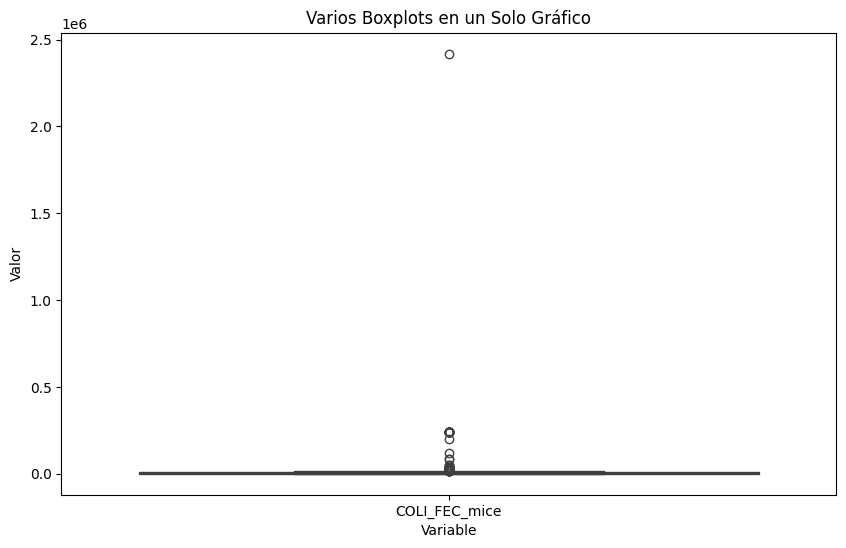

In [66]:
# Ejemplo de datos
data = {
    'Variable1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Variable2': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'Variable3': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
}
df = pd.concat([df_imputation_method['COLI_FEC_mice'], df_imputation_method.loc[estimate_IF_COLI_FEC_mice == 1, 'COLI_FEC_mice']], axis=1)

# Convertir el DataFrame a un formato largo (long format) para usarlo con Seaborn
df_long = df.melt(var_name='Variable', value_name='Valor')

# Crear el gráfico de boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Variable', y='Valor', data=df_long)
plt.title('Varios Boxplots en un Solo Gráfico')
plt.show()

<Axes: ylabel='COLI_FEC_ffill'>

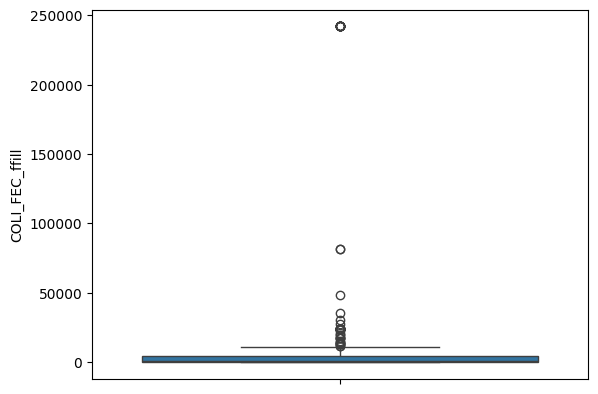

In [73]:
# Outliers

sns.boxplot(y=df_imputation_method.loc[estimate_IF_COLI_FEC_ffill == 1, 'COLI_FEC_ffill'])

<Axes: ylabel='COLI_FEC_ffill'>

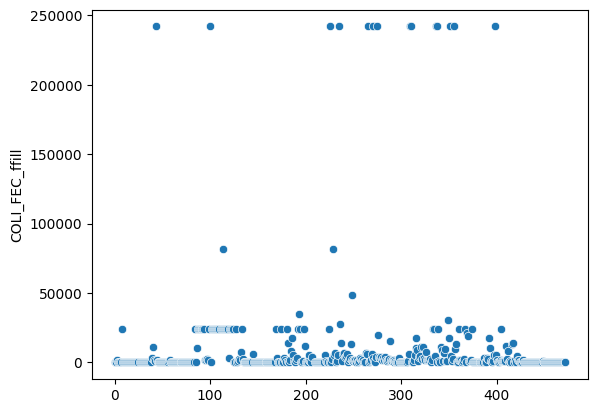

In [74]:
sns.scatterplot(df_imputation_method.loc[estimate_IF_COLI_FEC_ffill == 1, 'COLI_FEC_ffill'])


In [110]:
df_drop_water_sonora[df_drop_water_sonora['COLI_FEC'] > 100000]

,CLAVE SITIO,ESTADO,MUNICIPIO,CUERPO DE AGUA,TIPO CUERPO DE AGUA,SUBTIPO CUERPO AGUA,LATITUD,LONGITUD,FECHA REALIZACIÓN,COLI_FEC,...,AS_TOT,CD_TOT,CR_TOT,HG_TOT,NI_TOT,PB_TOT,DUR_TOT,TEMP_AMB,TEMP_AGUA,CAUDAL
25,MET-045,SONORA,URES,RIO SONORA,LÓTICO,RÍO,29.36277,-110.50018,2022-08-20,120330.0,...,0.1140,0.001301,0.0740,0.000600,0.09400,0.24800,NaN,27.0,25.0,18321.0
43,OCNOR3987,SONORA,CANANEA,RIO SONORA,LÓTICO,RÍO,30.95804,-110.18906,2014-07-09,241960.0,...,0.0142,0.001301,0.0074,0.000310,0.01120,0.03570,200.000,32.0,26.6,8.0
100,OCNOR3989,SONORA,CANANEA,ARROYO EL BARRILITO,LÓTICO (HUMEDAL),ARROYO,30.99713,-110.28877,2015-06-08,241960.0,...,0.0080,0.002200,0.0012,0.000201,0.00042,0.00154,251.940,34.0,25.1,42.4
110,OCNOR3989,SONORA,CANANEA,ARROYO EL BARRILITO,LÓTICO (HUMEDAL),ARROYO,30.99713,-110.28877,2017-02-24,2419600.0,...,0.0015,0.006300,0.0012,0.000201,0.01160,0.00154,435.040,17.0,14.8,169.9
208,OCNOR4017,SONORA,URES,RIO SONORA,LÓTICO,RÍO,29.32107,-110.54156,2022-08-20,198630.0,...,0.1260,0.001301,0.1780,0.000600,0.11200,0.26200,NaN,27.0,25.0,17404.0
225,OCNOR4019,SONORA,BAVIÁCORA,RIO SONORA,LÓTICO,RÍO,29.53502,-110.12087,2013-09-10,241960.0,...,0.0587,0.001301,0.0614,0.000300,0.07090,0.21990,223.972,34.5,28.2,10240.0
235,OCNOR4019,SONORA,BAVIÁCORA,RIO SONORA,LÓTICO,RÍO,29.53502,-110.12087,2015-07-15,241960.0,...,0.0485,0.001301,0.0277,0.000256,0.05050,0.00154,1054.970,33.0,29.8,1170.0
265,OCNOR4020,SONORA,BAVIÁCORA,RIO SONORA,LÓTICO,RÍO,29.72369,-110.17441,2013-09-10,241960.0,...,0.1377,0.010500,0.0532,0.000900,0.07050,0.69230,240.718,35.4,29.0,11200.0
270,OCNOR4020,SONORA,BAVIÁCORA,RIO SONORA,LÓTICO,RÍO,29.72369,-110.17441,2014-07-10,241960.0,...,0.3004,0.025200,0.1881,0.000150,0.34310,NaN,NaN,34.0,32.4,3900.0
275,OCNOR4020,SONORA,BAVIÁCORA,RIO SONORA,LÓTICO,RÍO,29.72369,-110.17441,2015-07-15,241960.0,...,0.0146,0.001301,0.0145,0.000201,0.01800,0.00154,298.320,38.0,29.4,780.0


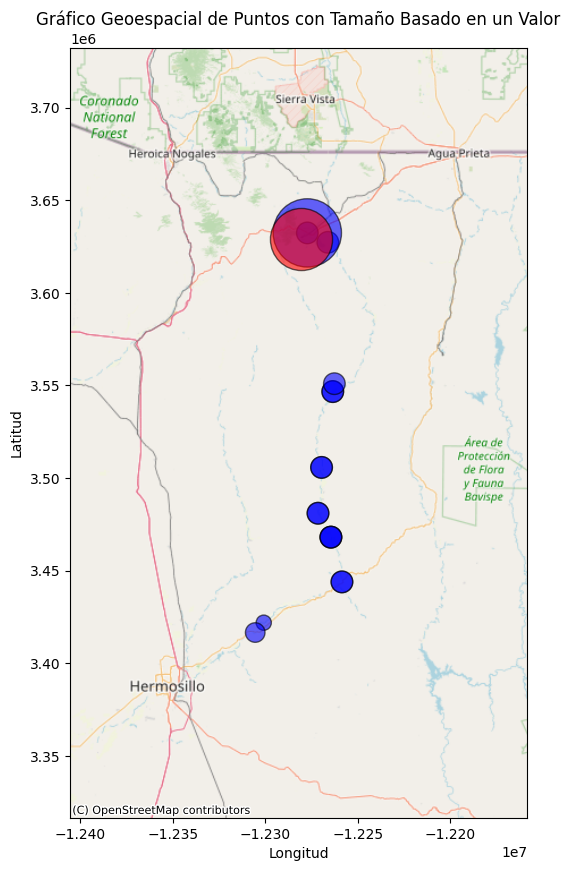

In [111]:
# Ejemplo de datos
data = {
    'latitude': [30.973333],
    'longitude': [-110.320278],
    'value': [1000000]  # Este es el valor que afectará el tamaño del punto
}
df = df_drop_water_sonora[df_drop_water_sonora['COLI_FEC'] > 100000][['LATITUD', 'LONGITUD', 'COLI_FEC']]
df2 = pd.DataFrame(data)

# Convertir el DataFrame a un GeoDataFrame con puntos geoespaciales
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['LONGITUD'], df['LATITUD']), crs="EPSG:4326")
gdf2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2['longitude'], df2['latitude']), crs="EPSG:4326")

# Convertir el sistema de coordenadas a Web Mercator para añadir un mapa de fondo
gdf = gdf.to_crs(epsg=3857)
gdf2 = gdf2.to_crs(epsg=3857)

# Crear la figura y el gráfico
fig, ax = plt.subplots(figsize=(15, 10))
gdf.plot(ax=ax, markersize=gdf['COLI_FEC']*0.001, color='blue', alpha=0.6, edgecolor='k', legend=True)
gdf2.plot(ax=ax, markersize=gdf2['value']*0.002, color='red', alpha=0.6, edgecolor='k', legend=True)


# Definir límites personalizados para el área a visualizar (ajusta según el área deseada)
ax.set_xlim([gdf.geometry.x.min() - 100000, gdf.geometry.x.max() + 100000])
ax.set_ylim([gdf.geometry.y.min() - 100000, gdf.geometry.y.max() + 100000])

# Añadir el mapa de fondo con un proveedor alternativo
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Ajustes adicionales
plt.title("Gráfico Geoespacial de Puntos con Tamaño Basado en un Valor")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


In [26]:
df_drop_water_sonora.sort_values('COLI_FEC', ascending=False).head(100)

,CLAVE SITIO,ESTADO,MUNICIPIO,CUERPO DE AGUA,TIPO CUERPO DE AGUA,SUBTIPO CUERPO AGUA,LATITUD,LONGITUD,FECHA REALIZACIÓN,COLI_FEC,...,AS_TOT,CD_TOT,CR_TOT,HG_TOT,NI_TOT,PB_TOT,DUR_TOT,TEMP_AMB,TEMP_AGUA,CAUDAL
110,OCNOR3989,SONORA,CANANEA,ARROYO EL BARRILITO,LÓTICO (HUMEDAL),ARROYO,30.99713,-110.28877,2017-02-24,2419600.0,...,0.0015,0.006300,0.0012,0.000201,0.01160,0.00154,435.040,17.0,14.8,169.9
351,OCNOR4024,SONORA,ARIZPE,RIO SONORA,LÓTICO,RÍO,30.33503,-110.16534,2013-09-10,241960.0,...,0.1029,0.001301,0.2526,0.000700,0.16430,0.58880,NaN,25.7,23.9,4740.0
43,OCNOR3987,SONORA,CANANEA,RIO SONORA,LÓTICO,RÍO,30.95804,-110.18906,2014-07-09,241960.0,...,0.0142,0.001301,0.0074,0.000310,0.01120,0.03570,200.000,32.0,26.6,8.0
355,OCNOR4024,SONORA,ARIZPE,RIO SONORA,LÓTICO,RÍO,30.33503,-110.16534,2014-07-10,241960.0,...,0.0381,0.003700,0.0344,0.000710,0.05210,0.11280,344.600,35.0,34.8,800.0
336,OCNOR4023,SONORA,BANÁMICHI,RIO SONORA,LÓTICO (HUMEDAL),RÍO,30.01704,-110.21963,2013-09-10,241960.0,...,0.0457,0.001301,0.0443,0.001200,0.03670,0.16500,188.388,31.5,28.0,3580.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,OCNOR4026,SONORA,ARIZPE,RIO BACANUCHI,LÓTICO,RÍO,30.36813,-110.15751,2016-09-28,8164.0,...,0.0015,0.001301,0.0203,0.000201,0.00042,0.00154,289.000,32.0,24.4,290.0
185,OCNOR4017,SONORA,URES,RIO SONORA,LÓTICO,RÍO,29.32107,-110.54156,2015-06-09,8164.0,...,0.0015,0.001301,0.0012,0.000201,0.35500,0.00154,395.350,36.0,32.8,53.5
132,OCNOR3990,SONORA,ACONCHI,RIO SONORA,LÓTICO,RÍO,29.84478,-110.27754,2014-04-23,7270.0,...,0.0207,0.001301,0.0012,0.000201,0.00042,0.00154,103.000,29.0,34.2,5.0
326,OCNOR4022,SONORA,ACONCHI,RIO SONORA,LÓTICO (HUMEDAL),RÍO,29.82440,-110.23701,2017-08-08,7270.0,...,0.0142,0.001301,0.0012,0.000201,0.00042,0.00154,326.980,42.0,33.2,432.8
